<a href="https://colab.research.google.com/github/codeslayr/Neural_Network_Optimization/blob/main/CNN_optimization_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline

In [ ]:
# Step 1: Imports & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Step 2: Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


In [ ]:
# Step 3: Define CNN Model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # output: (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: (32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: (64, 7, 7)

            nn.Flatten(),  # output: (64*7*7,)
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    loss_total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_total += loss.item()

    acc = 100 * correct / total
    avg_loss = loss_total / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")
    return avg_loss, acc

In [ ]:
train_model(model, train_loader, criterion, optimizer, epochs=5)
evaluate_model(model, test_loader)

Epoch [1/5], Loss: 402.1387, Accuracy: 84.59%
Epoch [2/5], Loss: 260.3443, Accuracy: 89.87%
Epoch [3/5], Loss: 215.9270, Accuracy: 91.50%
Epoch [4/5], Loss: 184.1140, Accuracy: 92.72%
Epoch [5/5], Loss: 158.0473, Accuracy: 93.75%
Test Loss: 0.2447, Test Accuracy: 91.50%


(0.24474794569478672, 91.5)

SGD

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and split FashionMNIST dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_dataset, val_dataset = random_split(full_train_dataset, [55000, 5000])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN Model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Random Search Config
search_space = {
    'lr': lambda: 10 ** np.random.uniform(-4, -1),
    'momentum': lambda: np.random.uniform(0.5, 0.99),
    'batch_size': lambda: random.choice([32, 64, 128]),
    'weight_decay': lambda: np.random.uniform(0.0, 1e-2)
}

results = []
best_config = None
best_acc = 0
best_epoch = -1
num_trials = 20

# Run random search
for trial in range(num_trials):
    config = {key: sampler() for key, sampler in search_space.items()}
    batch_size = int(config['batch_size'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = FashionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])

    train(model, train_loader, criterion, optimizer, epochs=3)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    results.append((config, val_loss, val_acc))
    print(f"Epoch {trial+1}/{num_trials} - Acc: {val_acc:.4f}, Loss: {val_loss:.4f}, Config: {config}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_config = config
        best_epoch = trial + 1

# Final training and evaluation
print(f"\n🔍 Best Hyperparameter Found at epoch {best_epoch} {best_config}")
print(f"Best hyperparameters from SGD: {best_config}")

final_model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_model.parameters(), lr=best_config['lr'], momentum=best_config['momentum'], weight_decay=best_config['weight_decay'])

combined_loader = DataLoader(full_train_dataset, batch_size=int(best_config['batch_size']), shuffle=True)
print()
for ep in range(5):
    train(final_model, combined_loader, criterion, optimizer, epochs=1)
    print(f"Epoch {ep+1} completed.")

test_loss, test_acc = evaluate(final_model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.3f}")

Epoch 1/20 - Acc: 0.8602, Loss: 0.3967, Config: {'lr': 0.0013292918943162155, 'momentum': 0.9658500101408589, 'batch_size': 128, 'weight_decay': 0.007319939418114051}
Epoch 2/20 - Acc: 0.8622, Loss: 0.3891, Config: {'lr': 0.006251373574521747, 'momentum': 0.5764491338167939, 'batch_size': 32, 'weight_decay': 0.0015599452033620265}
Epoch 3/20 - Acc: 0.8094, Loss: 0.5400, Config: {'lr': 0.00014936568554617627, 'momentum': 0.9244263114297182, 'batch_size': 32, 'weight_decay': 0.006011150117432088}
Epoch 4/20 - Acc: 0.8280, Loss: 0.4667, Config: {'lr': 0.013311216080736888, 'momentum': 0.5100864022049432, 'batch_size': 128, 'weight_decay': 0.009699098521619943}
Epoch 5/20 - Acc: 0.8840, Loss: 0.3160, Config: {'lr': 0.031428808908401065, 'momentum': 0.6040461642323554, 'batch_size': 64, 'weight_decay': 0.0018182496720710061}
Epoch 6/20 - Acc: 0.7632, Loss: 0.6316, Config: {'lr': 0.0003549878832196504, 'momentum': 0.6490786990501735, 'batch_size': 32, 'weight_decay': 0.005247564316322379}
Ep


Generating visualizations...


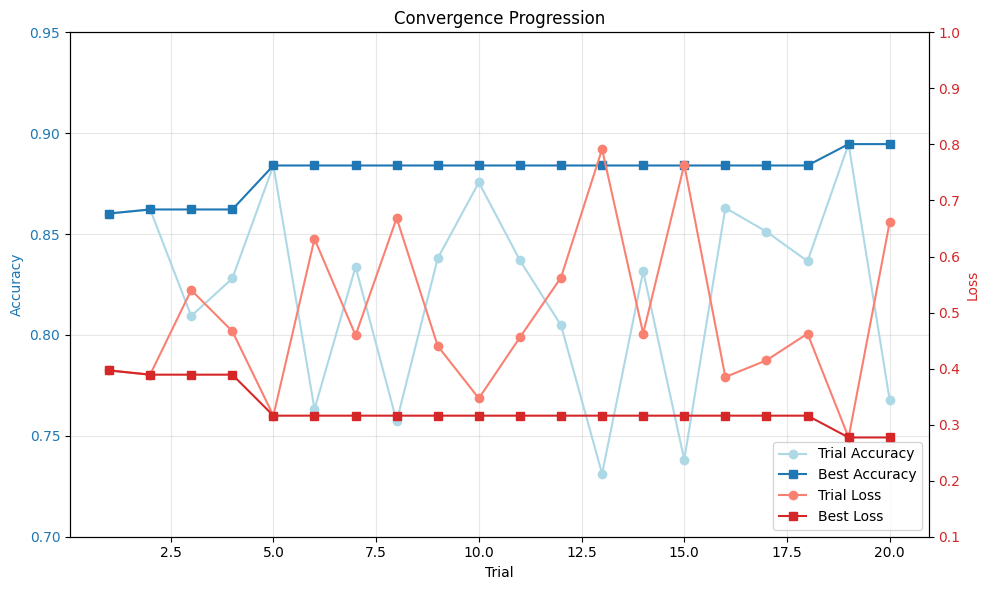

Generated Convergence Progression plots


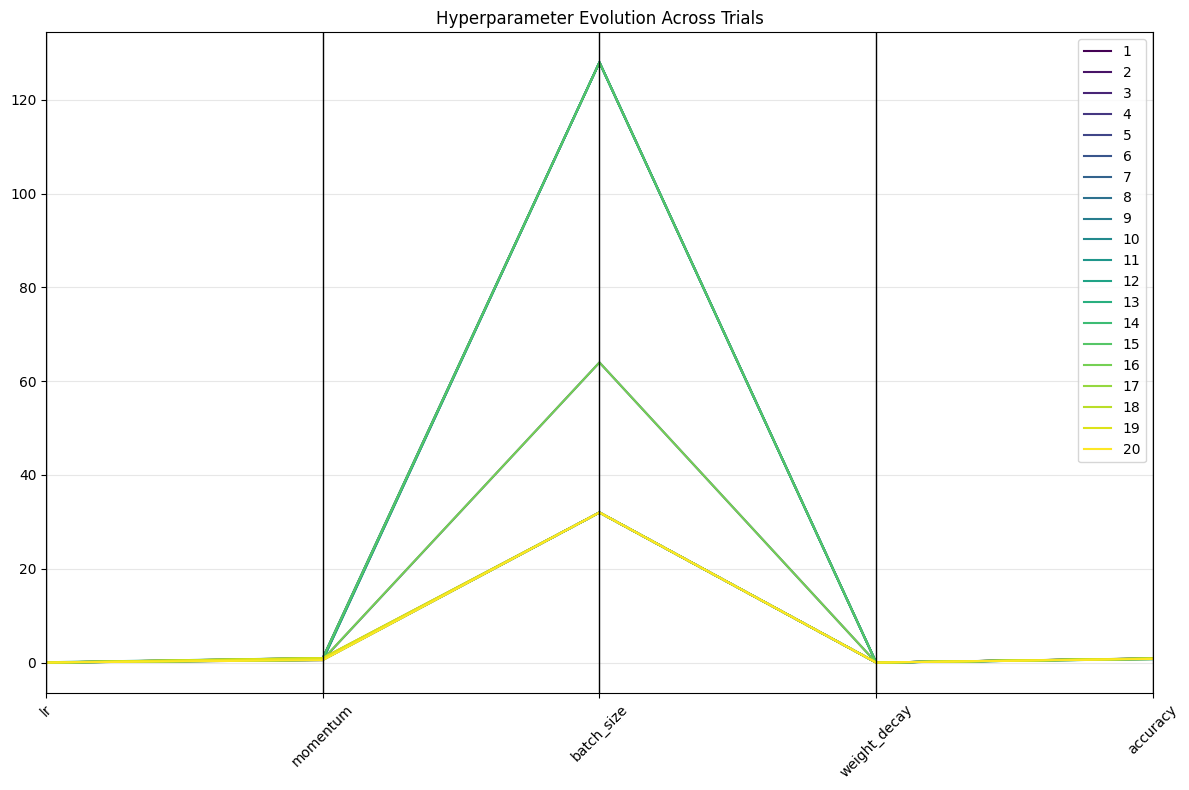

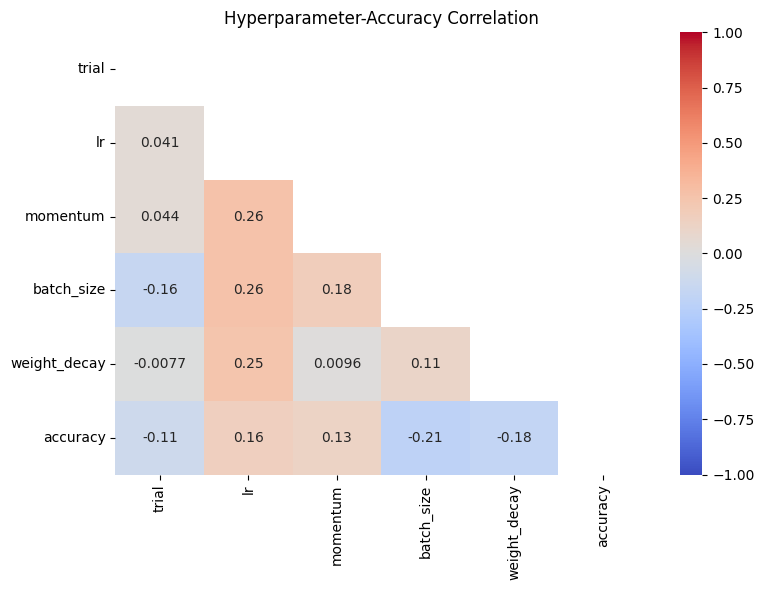

Generated Hyperparameter Evolution plots


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

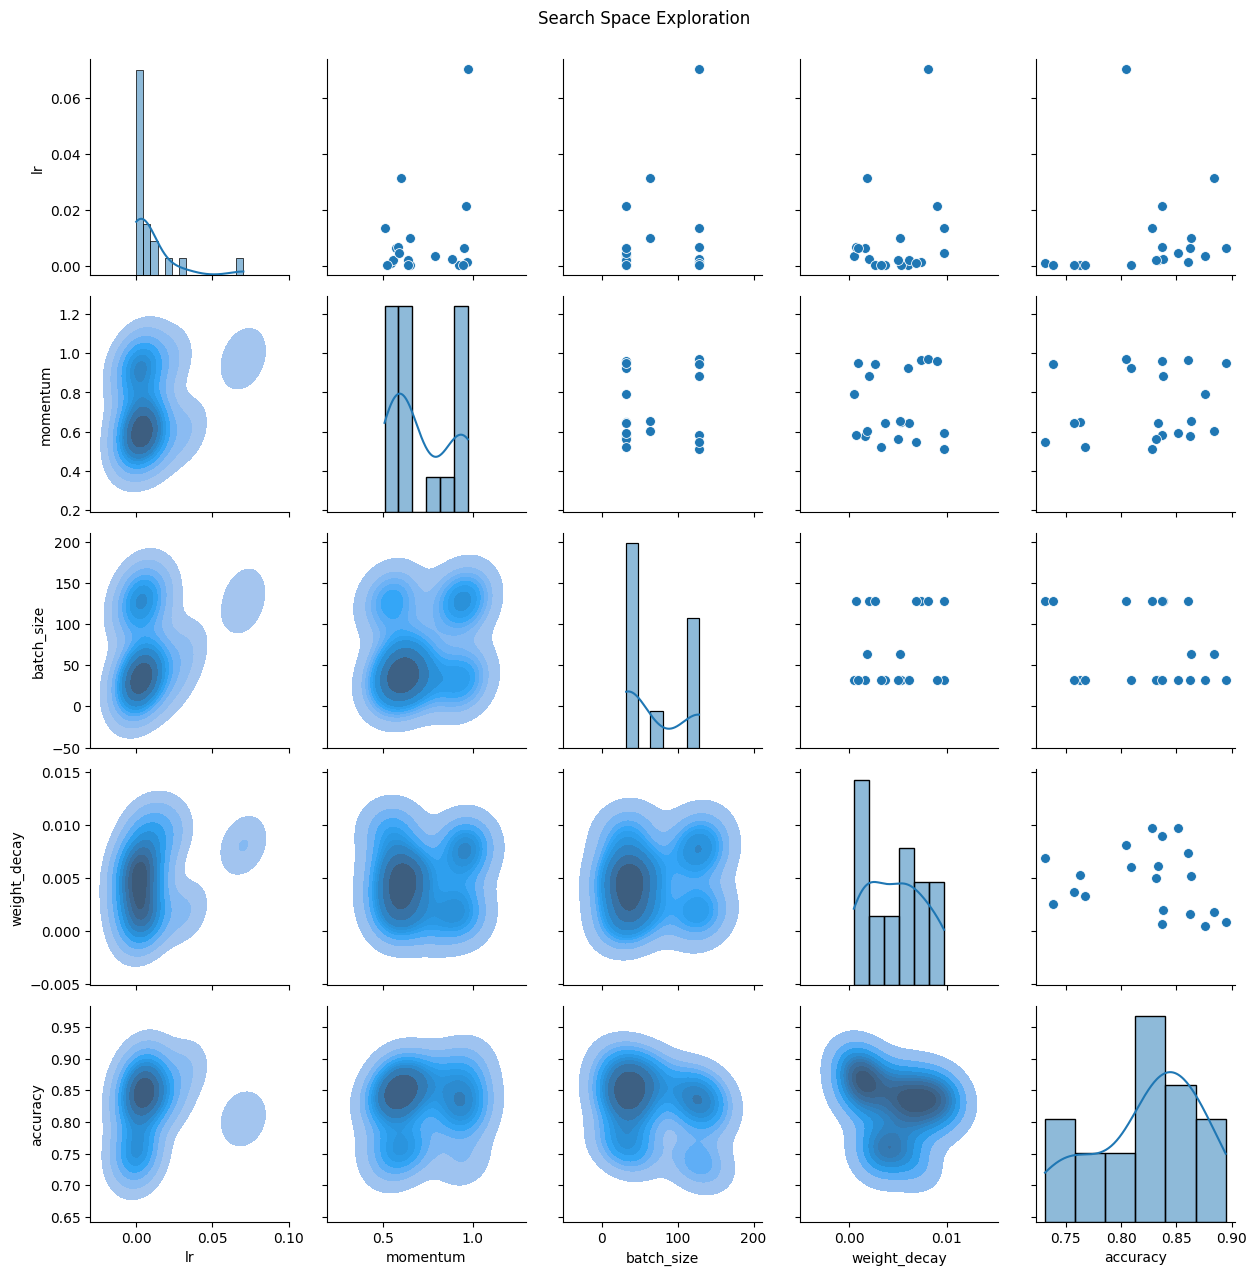

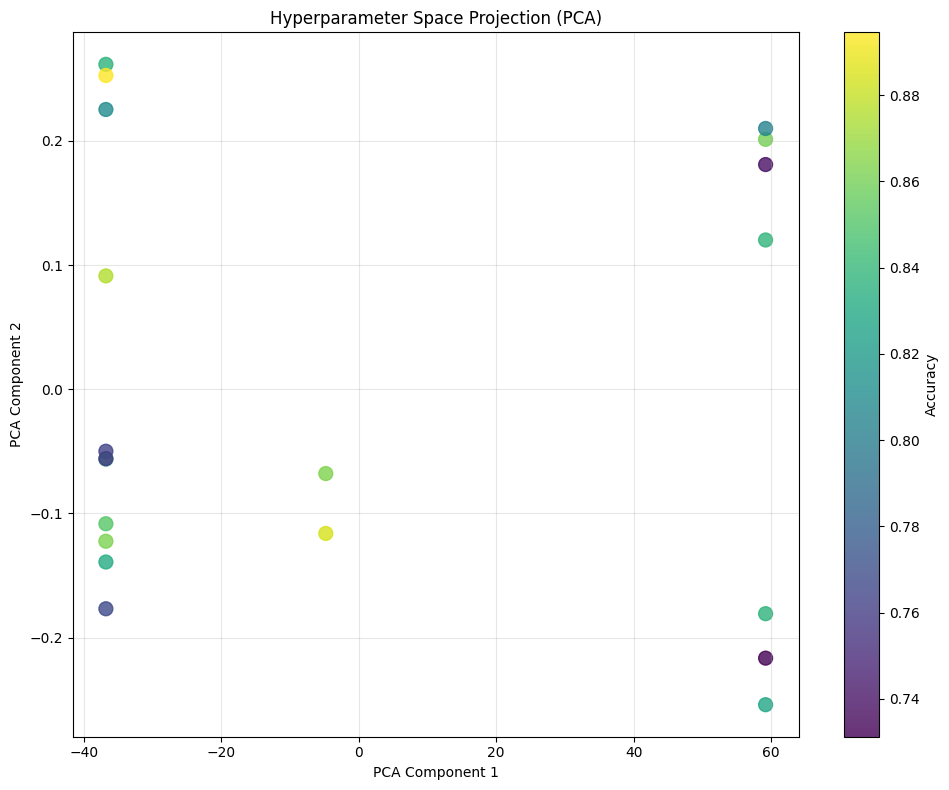

Generated Search Space Exploration plots
Epoch 1: Train Loss: 0.4721, Val Loss: 0.3459 | Train Acc: 0.8310, Val Acc: 0.8788
Epoch 2: Train Loss: 0.2912, Val Loss: 0.2853 | Train Acc: 0.8933, Val Acc: 0.8942
Epoch 3: Train Loss: 0.2529, Val Loss: 0.2659 | Train Acc: 0.9069, Val Acc: 0.9012
Epoch 4: Train Loss: 0.2276, Val Loss: 0.2501 | Train Acc: 0.9162, Val Acc: 0.9100
Epoch 5: Train Loss: 0.2126, Val Loss: 0.2512 | Train Acc: 0.9209, Val Acc: 0.9050


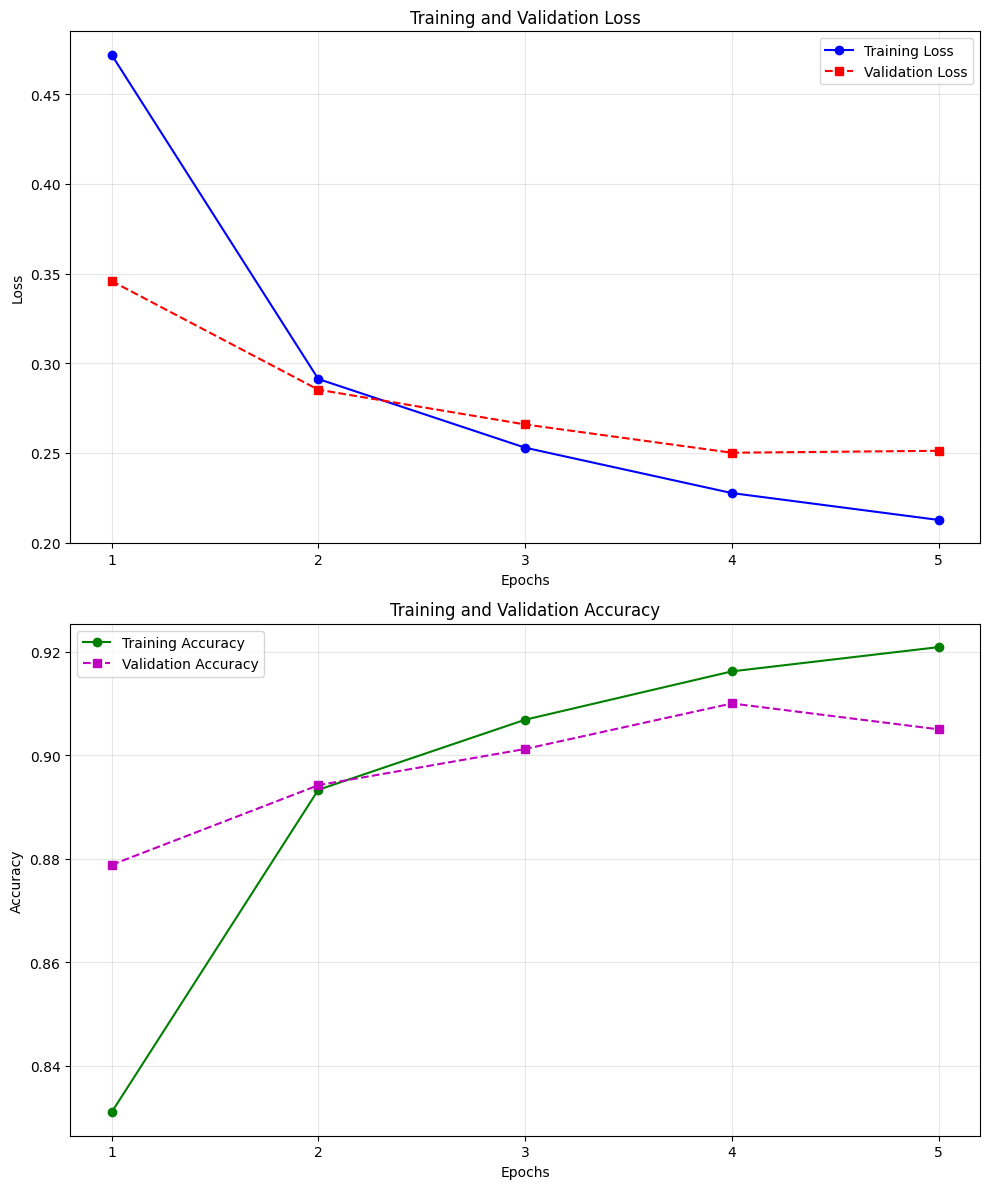

Generated Training Dynamics plot
Tracking computation profile (this will re-run trials)...


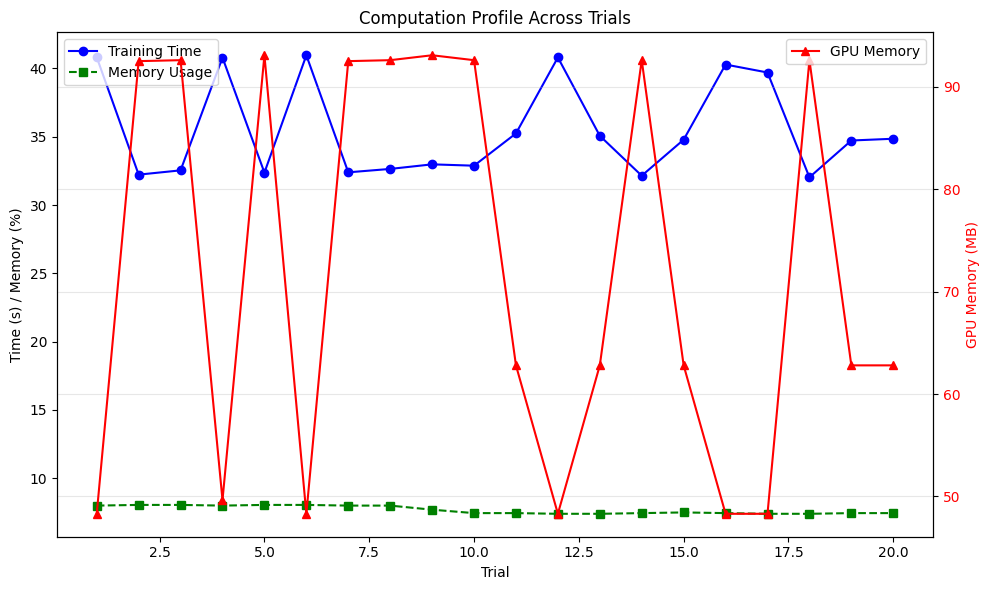

Generated Computation Profile plot


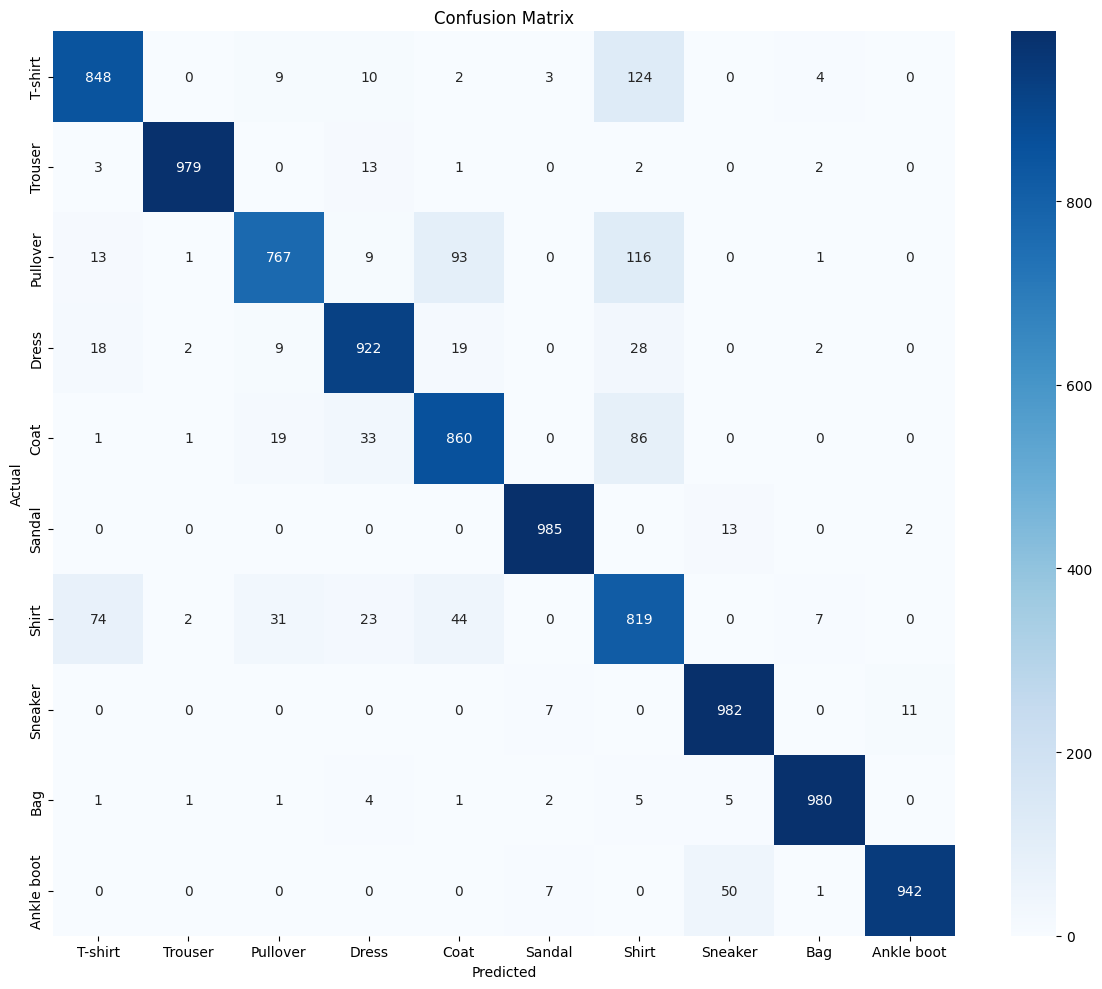

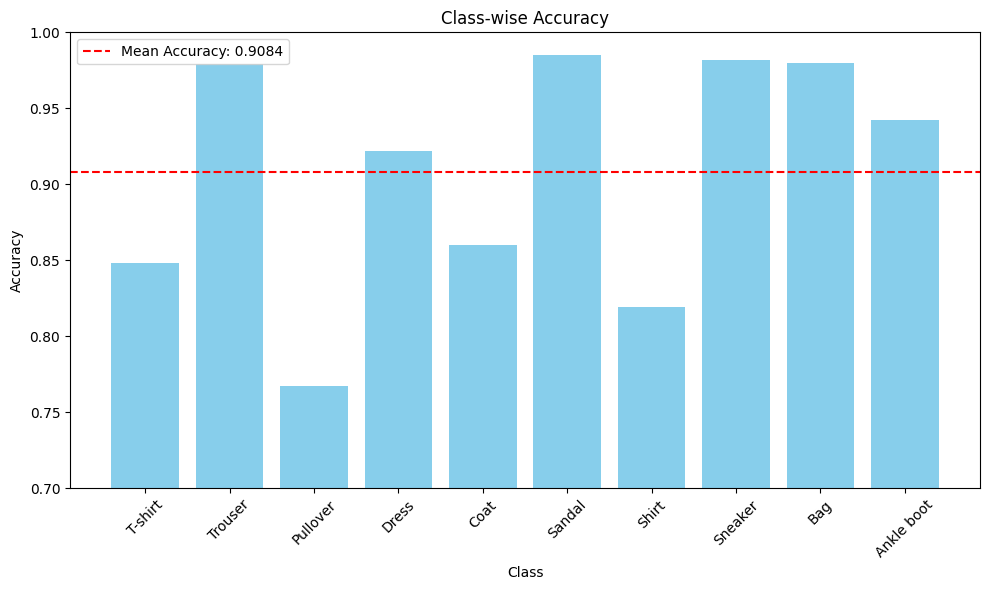

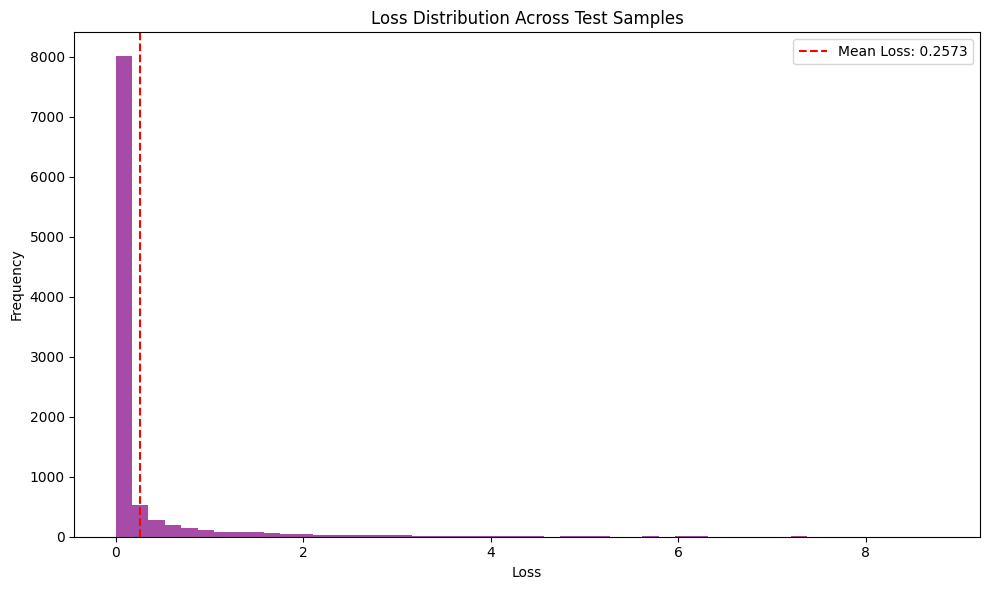

Generated Error Analysis plots

All visualizations saved to current directory!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import time
import psutil
from matplotlib.ticker import MaxNLocator


# 1. Convergence Progression
def plot_convergence(results):
    """Plot validation accuracy and loss progression across trials"""
    trials = range(1, len(results) + 1)
    val_accs = [res[2] for res in results]
    val_losses = [res[1] for res in results]

    # Find best accuracy positions
    best_accs = [max(val_accs[:i+1]) for i in range(len(val_accs))]
    best_losses = [min(val_losses[:i+1]) for i in range(len(val_losses))]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Accuracy plot
    color = 'tab:blue'
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(trials, val_accs, 'o-', color='lightblue', label='Trial Accuracy')
    ax1.plot(trials, best_accs, 's-', color=color, label='Best Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0.7, 0.95)
    ax1.grid(alpha=0.3)
    ax1.set_title('Convergence Progression')

    # Loss plot
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Loss', color=color)
    ax2.plot(trials, val_losses, 'o-', color='salmon', label='Trial Loss')
    ax2.plot(trials, best_losses, 's-', color=color, label='Best Loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0.1, 1.0)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

    plt.tight_layout()
    plt.show()
    plt.savefig('convergence_progression.png')
    plt.close()

# 2. Hyperparameter Evolution
def plot_hyperparameter_evolution(results):
    """Visualize hyperparameter trajectories and correlation with accuracy"""
    # Prepare data
    df = pd.DataFrame({
        'trial': range(1, len(results)+1),
        'lr': [res[0]['lr'] for res in results],
        'momentum': [res[0]['momentum'] for res in results],
        'batch_size': [res[0]['batch_size'] for res in results],
        'weight_decay': [res[0]['weight_decay'] for res in results],
        'accuracy': [res[2] for res in results]
    })

    # Parallel coordinates plot
    plt.figure(figsize=(12, 8))
    pd.plotting.parallel_coordinates(
        df, 'trial',
        cols=['lr', 'momentum', 'batch_size', 'weight_decay', 'accuracy'],
        color=plt.cm.viridis(np.linspace(0, 1, len(df)))
    )
    plt.xticks(rotation=45)
    plt.title('Hyperparameter Evolution Across Trials')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig('hyperparameter_evolution.png')
    plt.close()

    # Correlation matrix
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Hyperparameter-Accuracy Correlation')
    plt.tight_layout()
    plt.show()
    plt.savefig('hyperparameter_correlation.png')
    plt.close()

# 3. Search Space Exploration
def plot_search_space_exploration(results):
    """Visualize hyperparameter distribution and density"""
    # Prepare data
    df = pd.DataFrame({
        'lr': [res[0]['lr'] for res in results],
        'momentum': [res[0]['momentum'] for res in results],
        'batch_size': [res[0]['batch_size'] for res in results],
        'weight_decay': [res[0]['weight_decay'] for res in results],
        'accuracy': [res[2] for res in results]
    })

    # Pairwise relationships
    g = sns.PairGrid(df, diag_sharey=False)
    g.map_upper(sns.scatterplot, s=50)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot, kde=True)
    g.fig.suptitle('Search Space Exploration', y=1.02)
    plt.show()
    plt.savefig('search_space_pairplot.png')
    plt.close()

    # PCA projection
    pca = PCA(n_components=2)
    params = df[['lr', 'momentum', 'batch_size', 'weight_decay']]
    pca_result = pca.fit_transform(params)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        pca_result[:, 0], pca_result[:, 1],
        c=df['accuracy'], cmap='viridis', s=100, alpha=0.8
    )
    plt.colorbar(scatter, label='Accuracy')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Hyperparameter Space Projection (PCA)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig('search_space_pca.png')
    plt.close()

# 4. Training Dynamics (For Best Run)
def plot_training_dynamics(model, train_loader, val_loader):
    """Plot training and validation metrics during training"""
    # Track metrics during training
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=best_config['lr'],
                          momentum=best_config['momentum'],
                          weight_decay=best_config['weight_decay'])

    for epoch in range(5):
        # Training
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = epoch_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Loss plot
    epochs = range(1, 6)
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r--s', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'g-o', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'm--s', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()
    plt.savefig('training_dynamics.png')
    plt.close()

    return train_losses, train_accs, val_losses, val_accs

# 5. Computation Profile (Modified Training Loop)
def track_computation_profile():
    """Track computational resources during training"""
    # Modify training function to track resources
    train_times = []
    cpu_usages = []
    mem_usages = []
    gpu_usages = []

    for trial in range(num_trials):
        config = {key: sampler() for key, sampler in search_space.items()}
        batch_size = int(config['batch_size'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = FashionCNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=config['lr'],
                              momentum=config['momentum'],
                              weight_decay=config['weight_decay'])

        # Start tracking
        start_time = time.time()
        cpu_before = psutil.cpu_percent()
        mem_before = psutil.virtual_memory().percent

        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)
            gpu_before = torch.cuda.memory_allocated(device) / (1024 ** 2)  # MB

        # Training
        model.train()
        for epoch in range(3):
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # End tracking
        train_time = time.time() - start_time
        cpu_after = psutil.cpu_percent()
        mem_after = psutil.virtual_memory().percent

        if torch.cuda.is_available():
            gpu_after = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # MB
        else:
            gpu_after = 0

        train_times.append(train_time)
        cpu_usages.append((cpu_before + cpu_after) / 2)
        mem_usages.append((mem_before + mem_after) / 2)
        gpu_usages.append(gpu_after)

        # Evaluation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        results.append((config, val_loss, val_acc))

    # Plot computation profile
    trials = range(1, num_trials+1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Time and Memory
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Time (s) / Memory (%)')
    ax1.plot(trials, train_times, 'b-o', label='Training Time')
    ax1.plot(trials, mem_usages, 'g--s', label='Memory Usage')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    # GPU Usage
    if torch.cuda.is_available():
        ax2 = ax1.twinx()
        ax2.set_ylabel('GPU Memory (MB)', color='r')
        ax2.plot(trials, gpu_usages, 'r-^', label='GPU Memory')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend(loc='upper right')

    plt.title('Computation Profile Across Trials')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig('computation_profile.png')
    plt.close()

    return train_times, cpu_usages, mem_usages, gpu_usages

# 6. Error Analysis
def plot_error_analysis(model, test_loader):
    """Analyze model errors with confusion matrix and class metrics"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Class-wise accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_acc, color='skyblue')
    plt.axhline(np.mean(class_acc), color='r', linestyle='--',
                label=f'Mean Accuracy: {np.mean(class_acc):.4f}')
    plt.ylim(0.7, 1.0)
    plt.title('Class-wise Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig('class_accuracy.png')
    plt.close()

    # Loss distribution (sample level)
    model.eval()
    losses = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = nn.CrossEntropyLoss(reduction='none')(outputs, labels)
            losses.extend(loss.cpu().numpy())

    plt.figure(figsize=(10, 6))
    plt.hist(losses, bins=50, color='purple', alpha=0.7)
    plt.axvline(np.mean(losses), color='r', linestyle='--',
                label=f'Mean Loss: {np.mean(losses):.4f}')
    plt.title('Loss Distribution Across Test Samples')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig('loss_distribution.png')
    plt.close()

    return cm, class_acc, losses

# Main Execution
if __name__ == "__main__":
    # Run after your optimization code
    print("\nGenerating visualizations...")

    # 1. Convergence Progression
    plot_convergence(results)
    print("Generated Convergence Progression plots")

    # 2. Hyperparameter Evolution
    plot_hyperparameter_evolution(results)
    print("Generated Hyperparameter Evolution plots")

    # 3. Search Space Exploration
    plot_search_space_exploration(results)
    print("Generated Search Space Exploration plots")

    # 4. Training Dynamics (for best model)
    # Prepare dataloaders for training dynamics
    batch_size = int(best_config['batch_size'])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create a new model for training dynamics
    model_dynamics = FashionCNN().to(device)
    plot_training_dynamics(model_dynamics, train_loader, val_loader)
    print("Generated Training Dynamics plot")

    # 5. Computation Profile (requires modified training loop)
    # We need to re-run the optimization with tracking
    print("Tracking computation profile (this will re-run trials)...")
    # Save previous results
    original_results = results.copy()
    results = []
    track_computation_profile()
    # Restore original results
    results = original_results
    print("Generated Computation Profile plot")

    # 6. Error Analysis (on final model)
    plot_error_analysis(final_model, test_loader)
    print("Generated Error Analysis plots")

    print("\nAll visualizations saved to current directory!")

LBFGS

Using device: cuda
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Trial 1/20 — Val Acc: 0.7294, Val Loss: 0.7925, Time: 11.6s, CFG: {'lr': 0.05611516415334504, 'batch_size': 64, 'weight_decay': 0.009507143064099163}
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Trial 2/20 — Val Acc: 0.7748, Val Loss: 0.6971, Time: 29.8s, CFG: {'lr': 0.2910635913133069, 'batch_size': 16, 'weight_decay': 0.005986584841970366}
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Trial 3/20 — Val Acc: 0.7922, Val Loss: 0.6158, Time: 28.3s, CFG: {'lr': 0.020513382630874495, 'batch_size': 16, 'weight_decay': 0.0015599452033620265}
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Trial 4/20 — Val Acc: 0.6410, Val Loss: 0.9286, Time: 10.8s, CFG: {'lr': 0.013066739238053278, 'batch_size': 64, 'weight_decay': 0.008661761457749353}
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Trial 5/20 — Val Acc: 0.7580, Val Loss: 0.6851, Time: 17.2s, CFG: {'lr': 0.15930522616241008, 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

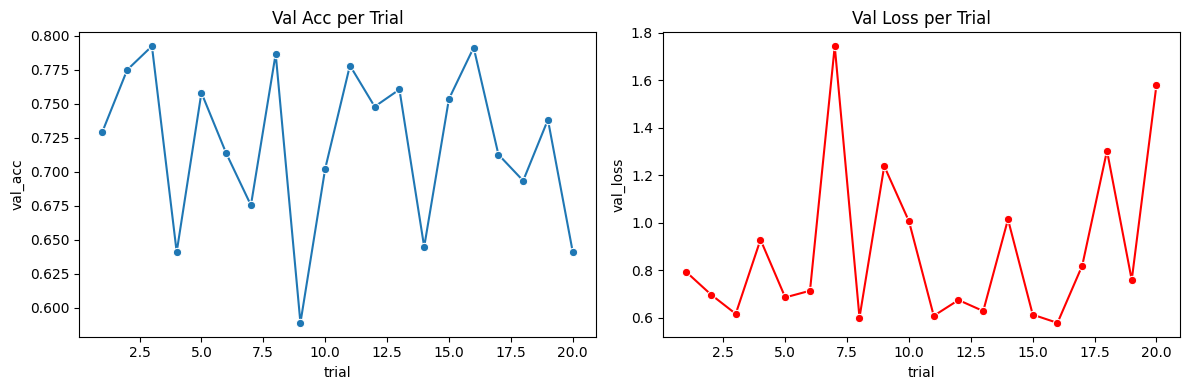

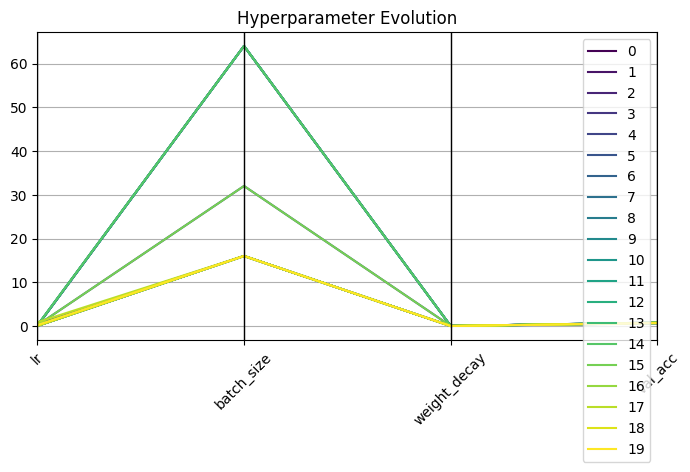

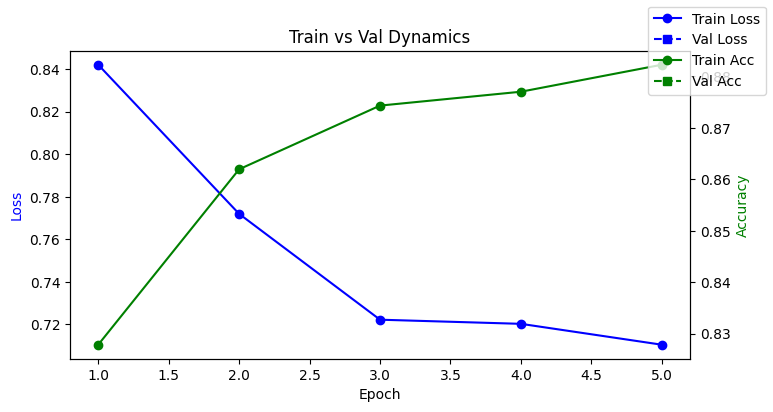

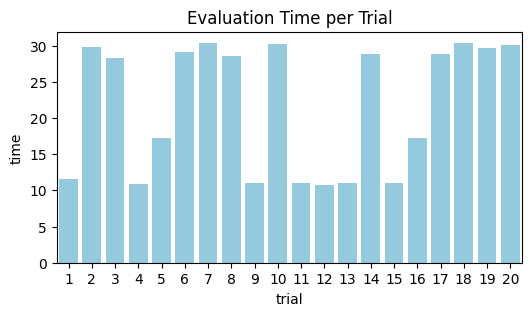

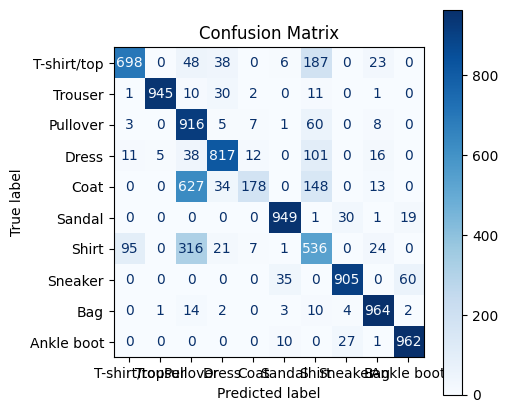

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



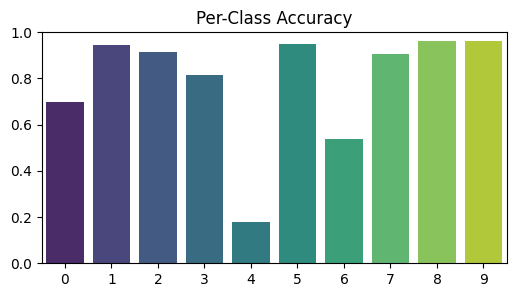

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px

# ————————— Set seeds & device —————————
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ————————— Data Prep —————————
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_ds, val_ds = random_split(full_train, [55000,5000])
test_ds = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# subset for search
subset_size=5000
train_sub = Subset(train_ds, list(range(subset_size)))
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

# ————————— Model —————————
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64*7*7,128), nn.ReLU(), nn.Linear(128,10)
        )
    def forward(self,x): return self.net(x)

criterion = nn.CrossEntropyLoss()

# ————————— Train/Eval Helpers —————————
def train_lbfgs(model, loader, criterion, optimizer, epochs=3, weight_decay=0.0):
    history = {'train_loss':[], 'train_acc':[]}
    model.train()
    for ep in range(epochs):
        total_loss, correct, total = 0.0,0,0
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            def closure():
                optimizer.zero_grad()
                out = model(imgs)
                loss = criterion(out,labs)
                if weight_decay>0:
                    l2 = sum(p.pow(2).sum() for p in model.parameters())
                    loss = loss + weight_decay*l2
                loss.backward()
                return loss
            loss = optimizer.step(closure)
            total_loss += loss.item()
            with torch.no_grad():
                preds = model(imgs).argmax(1)
                correct += (preds==labs).sum().item()
                total += labs.size(0)
        history['train_loss'].append(total_loss/len(loader))
        history['train_acc'].append(correct/total)
        print(f"Epoch {ep+1} completed.")
    return history

def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, correct, total = 0.0,0,0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out = model(imgs)
            tot_loss += criterion(out,labs).item()
            preds = out.argmax(1)
            correct += (preds==labs).sum().item()
            total += labs.size(0)
    return tot_loss/len(loader), correct/total

# ————————— Hyperparameter Search —————————
search_space = {
    'lr':          lambda: 10**np.random.uniform(-2,0),
    'batch_size':  lambda: random.choice([16,32,64]),
    'weight_decay':lambda: np.random.uniform(0,1e-2)
}

results = []
best_acc,best_cfg,best_trial=0, None, -1
num_trials=20

for t in range(num_trials):
    cfg = {k:fn() for k,fn in search_space.items()}
    bs,wd,lr = int(cfg['batch_size']), cfg['weight_decay'], cfg['lr']
    train_loader = DataLoader(train_sub, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False)

    model = FashionCNN().to(device)
    optimizer = optim.LBFGS(
        model.parameters(), lr=lr, max_iter=5,
        history_size=10, line_search_fn='strong_wolfe'
    )

    start=time.time()
    _ = train_lbfgs(model, train_loader, criterion, optimizer, epochs=3, weight_decay=wd)
    val_loss,val_acc = evaluate(model, val_loader, criterion)
    elapsed = time.time() - start

    results.append((cfg, val_loss, val_acc, elapsed))
    print(f"Trial {t+1}/{num_trials} — Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {elapsed:.1f}s, CFG: {cfg}")

    if val_acc > best_acc:
        best_acc,best_cfg,best_trial = val_acc,cfg,t+1

print(f"\n🔍 Best Hyperparameter Found at trial {best_trial}: {best_cfg}")

# ————————— Final Retrain & Dynamics —————————
full_loader = DataLoader(full_train, batch_size=int(best_cfg['batch_size']), shuffle=True)
test_loader = DataLoader(test_ds, batch_size=int(best_cfg['batch_size']), shuffle=False)

model = FashionCNN().to(device)
optimizer = optim.LBFGS(
    model.parameters(), lr=best_cfg['lr'],
    max_iter=5, history_size=10, line_search_fn='strong_wolfe'
)
train_dyn = train_lbfgs(model, full_loader, criterion, optimizer, epochs=5, weight_decay=best_cfg['weight_decay'])
test_loss,test_acc = evaluate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.6f}, Test Acc: {test_acc:.3f}")

# ————————— 1. Convergence Progression —————————
df_conv = pd.DataFrame([
    {'trial': i+1, 'val_acc': acc, 'val_loss': loss, 'time': tm}
    for i, (_, loss, acc, tm) in enumerate(results)
])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.lineplot(data=df_conv, x='trial', y='val_acc', marker='o')
plt.title("Val Acc per Trial")
plt.subplot(1,2,2)
sns.lineplot(data=df_conv, x='trial', y='val_loss', marker='o', color='r')
plt.title("Val Loss per Trial")
plt.tight_layout()
plt.show()

# ————————— 2. Hyperparameter Evolution —————————
df_hp = df_conv.copy()
for i,(cfg,_,_,_) in enumerate(results):
    for k in ['lr','batch_size','weight_decay']:
        df_hp.loc[i,k] = cfg[k]
df_pc = df_hp[['lr','batch_size','weight_decay','val_acc']].copy()
df_pc['idx'] = df_pc.index.astype(str)
plt.figure(figsize=(8,4))
parallel_coordinates(df_pc.rename(columns={'idx':'trial'}), 'trial',
                     cols=['lr','batch_size','weight_decay','val_acc'],
                     color=plt.cm.viridis(np.linspace(0,1,len(df_pc))))
plt.xticks(rotation=45); plt.title("Hyperparameter Evolution"); plt.show()

# ————————— 3. Search Space Exploration —————————
X = df_hp[['lr','batch_size','weight_decay']].astype(float)
Xp = StandardScaler().fit_transform(X)
pcs = PCA(3).fit_transform(Xp)
df_pca = pd.DataFrame(pcs,columns=['PC1','PC2','PC3'])
df_pca['val_acc'] = df_hp['val_acc']

fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3',
                    color='val_acc', size='val_acc',
                    title="Search Space Exploration (PCA)")
fig.show()

# ————————— 4. Training Dynamics —————————
epochs = list(range(1,len(train_dyn['train_loss'])+1))
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(epochs, train_dyn['train_loss'], 'b-o', label='Train Loss')
ax1.plot(epochs, train_dyn['val_loss']  if 'val_loss' in train_dyn else [None]*len(epochs),
         'b--s', label='Val Loss')
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss", color='b')
ax2 = ax1.twinx()
ax2.plot(epochs, train_dyn['train_acc'], 'g-o', label='Train Acc')
ax2.plot(epochs, train_dyn.get('val_acc',[None]*len(epochs)), 'g--s', label='Val Acc')
ax2.set_ylabel("Accuracy", color='g')
plt.title("Train vs Val Dynamics"); fig.legend(loc='upper right'); plt.show()

# ————————— 5. Computation Profile —————————
plt.figure(figsize=(6,3))
sns.barplot(x='trial',y='time',data=df_conv,color='skyblue')
plt.title("Evaluation Time per Trial"); plt.show()

# ————————— 6. Error Analysis —————————
# Confusion Matrix
all_preds,all_lbls=[],[]
model.eval()
with torch.no_grad():
    for ims,lbs in test_loader:
        ims,lbs=ims.to(device),lbs.to(device)
        out=model(ims).argmax(1)
        all_preds+=out.cpu().tolist()
        all_lbls+=lbs.cpu().tolist()

cm = confusion_matrix(all_lbls,all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_ds.classes)
fig,ax=plt.subplots(figsize=(5,5))
disp.plot(ax=ax,cmap='Blues')
plt.title("Confusion Matrix"); plt.show()
# Class-wise accuracy
accs = cm.diagonal()/cm.sum(axis=1)
plt.figure(figsize=(6,3))
sns.barplot(x=list(range(10)), y=accs, palette='viridis')
plt.title("Per-Class Accuracy"); plt.ylim(0,1); plt.show()

GA

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
from copy import deepcopy

# GPU Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
val_size = 5000
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [len(train_dataset)-val_size, val_size])
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# CNN Model Builder
class CNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, fc_units):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = (conv2_out * 7 * 7)
        self.fc1 = nn.Linear(self.flatten_size, fc_units)
        self.fc2 = nn.Linear(fc_units, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# GA Hyperparameters
POP_SIZE = 20
GENERATIONS = 20
TOP_K = 4

param_bounds = {
    "lr": [1e-4, 1e-2],
    "conv1_out": [16, 64],
    "conv2_out": [32, 128],
    "fc_units": [64, 256],
}

def random_gene():
    return {
        "lr": round(10 ** random.uniform(np.log10(param_bounds['lr'][0]), np.log10(param_bounds['lr'][1])), 5),
        "conv1_out": random.randint(*param_bounds['conv1_out']),
        "conv2_out": random.randint(*param_bounds['conv2_out']),
        "fc_units": random.randint(*param_bounds['fc_units'])
    }

def mutate(gene):
    mutated = deepcopy(gene)
    key = random.choice(list(param_bounds.keys()))
    return random_gene() if random.random() < 0.3 else gene

def crossover(parent1, parent2):
    child = {}
    for key in param_bounds:
        child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
    return child

# Fitness Evaluation
def evaluate(gene):
    model = CNN(gene['conv1_out'], gene['conv2_out'], gene['fc_units']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=gene['lr'])
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(1):  # train only 1 epoch
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    return val_loss, accuracy

# Genetic Algorithm Core
def run_ga():
    population = [random_gene() for _ in range(POP_SIZE)]

    # Create history storage
    ga_history = []

    best_overall = None
    best_loss = float('inf')
    best_acc = 0.0
    best_gen = -1

    for gen in range(GENERATIONS):
        # Evaluate all individuals
        scored = []
        for gene in population:
            loss, acc = evaluate(gene)
            scored.append((gene, loss, acc))  # <-- MODIFIED TO STORE TUPLE

        scored.sort(key=lambda x: x[1])  # sort by loss

        best_gene, loss, acc = scored[0]

        # Track global best
        if loss < best_loss:
            best_loss = loss
            best_acc = acc
            best_overall = best_gene
            best_gen = gen

        print(f"Gen {gen}: Best Loss = {loss:.4f}, Acc = {acc:.4f}")
        print(f"         Best Hyperparams @ Gen {gen}: {best_gene}")

        # ======== STORE GENERATION HISTORY ======== <-- ADD THIS BLOCK
        gen_data = {
            'generation': gen,
            'population': [gene for gene, _, _ in scored],
            'fitness': [(loss, acc) for _, loss, acc in scored],
            'best_gene': best_gene,
            'best_loss': loss,
            'best_acc': acc
        }
        ga_history.append(gen_data)
        # ======== END HISTORY STORAGE ========

        # Genetic operations
        top_genes = [x[0] for x in scored[:TOP_K]]
        new_pop = top_genes.copy()

        while len(new_pop) < POP_SIZE:
            p1, p2 = random.sample(top_genes, 2)
            child = crossover(p1, p2)
            child = mutate(child)
            new_pop.append(child)

        population = new_pop

    print(f"\n✅ Best hyperparameters found at generation {best_gen}: {best_overall}")
    print(f"   Final Best Loss = {best_loss:.4f}, Accuracy = {best_acc:.4f}")
    return best_overall, ga_history

# Run GA
best_hyperparams, ga_history = run_ga()
print("\nBest hyperparameters found:", best_hyperparams)

Gen 0: Best Loss = 0.2850, Acc = 0.8940
         Best Hyperparams @ Gen 0: {'lr': 0.00219, 'conv1_out': 47, 'conv2_out': 99, 'fc_units': 227}
Gen 1: Best Loss = 0.2903, Acc = 0.8974
         Best Hyperparams @ Gen 1: {'lr': 0.00172, 'conv1_out': 59, 'conv2_out': 114, 'fc_units': 108}
Gen 2: Best Loss = 0.2788, Acc = 0.8946
         Best Hyperparams @ Gen 2: {'lr': 0.00202, 'conv1_out': 42, 'conv2_out': 99, 'fc_units': 189}
Gen 3: Best Loss = 0.2804, Acc = 0.8996
         Best Hyperparams @ Gen 3: {'lr': 0.00202, 'conv1_out': 42, 'conv2_out': 114, 'fc_units': 189}
Gen 4: Best Loss = 0.2818, Acc = 0.8938
         Best Hyperparams @ Gen 4: {'lr': 0.00219, 'conv1_out': 60, 'conv2_out': 99, 'fc_units': 189}
Gen 5: Best Loss = 0.2831, Acc = 0.8904
         Best Hyperparams @ Gen 5: {'lr': 0.00219, 'conv1_out': 42, 'conv2_out': 114, 'fc_units': 189}
Gen 6: Best Loss = 0.2819, Acc = 0.8966
         Best Hyperparams @ Gen 6: {'lr': 0.00219, 'conv1_out': 42, 'conv2_out': 114, 'fc_units': 189}
Ge

In [ ]:
# Load Official Test Dataset
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate Best Hyperparams on Test Set
def train_and_test(hparams, epochs=5):
    model = CNN(hparams['conv1_out'], hparams['conv2_out'], hparams['fc_units']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    criterion = nn.CrossEntropyLoss()

    print(f"\n🔁 Training final model for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed.")

    # Test
    model.eval()
    test_loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    print(f"\n📊 Final Evaluation on Test Set:")
    print(f"   Test Loss     = {test_loss:.4f}")
    print(f"   Test Accuracy = {accuracy:.4f}")

# Evaluate on test set
train_and_test(best_hyperparams)


🔁 Training final model for 5 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.

📊 Final Evaluation on Test Set:
   Test Loss     = 0.2637
   Test Accuracy = 0.9138


PSO

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
from copy import deepcopy

# ------------------------------
# Device Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Dataset (Subset for Speed)
# ------------------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
val_size = 5000
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# Test Set (Official Evaluation)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# ------------------------------
# CNN Definition
# ------------------------------
class CNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, fc_units):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = conv2_out * 7 * 7
        self.fc1 = nn.Linear(self.flatten_size, fc_units)
        self.fc2 = nn.Linear(fc_units, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------
# Hyperparameter Bounds
# ------------------------------
param_bounds = {
    'lr': [1e-4, 1e-2],
    'conv1_out': [16, 64],
    'conv2_out': [32, 128],
    'fc_units': [64, 256]
}

# ------------------------------
# Fitness Function
# ------------------------------
def evaluate(hparams):
    model = CNN(int(hparams['conv1_out']), int(hparams['conv2_out']), int(hparams['fc_units'])).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    criterion = nn.CrossEntropyLoss()

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx >= 9:  # train on 10 mini-batches
            break

    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    return val_loss, accuracy

# ------------------------------
# PSO Core
# ------------------------------
def run_pso(particles=10, generations=20, w=0.5, c1=1.5, c2=1.5):
    def init_particle():
        return {
            'lr': 10 ** random.uniform(np.log10(param_bounds['lr'][0]), np.log10(param_bounds['lr'][1])),
            'conv1_out': random.randint(*param_bounds['conv1_out']),
            'conv2_out': random.randint(*param_bounds['conv2_out']),
            'fc_units': random.randint(*param_bounds['fc_units'])
        }

    def clip(hp):
        hp['lr'] = float(np.clip(hp['lr'], *param_bounds['lr']))
        hp['conv1_out'] = int(np.clip(round(hp['conv1_out']), *param_bounds['conv1_out']))
        hp['conv2_out'] = int(np.clip(round(hp['conv2_out']), *param_bounds['conv2_out']))
        hp['fc_units'] = int(np.clip(round(hp['fc_units']), *param_bounds['fc_units']))
        return hp

    population = [init_particle() for _ in range(particles)]
    velocity = [{k: 0.0 for k in p} for p in population]

    personal_best = deepcopy(population)
    personal_best_scores = []
    personal_best_accs = []

    for p in personal_best:
        loss, acc = evaluate(p)
        personal_best_scores.append(loss)
        personal_best_accs.append(acc)

    global_best_idx = np.argmin(personal_best_scores)
    global_best = deepcopy(personal_best[global_best_idx])
    global_best_loss = personal_best_scores[global_best_idx]
    global_best_acc = personal_best_accs[global_best_idx]

    pso_history = []

    for gen in range(generations):
        for i in range(particles):
            new_vel = {}
            new_pos = {}
            for key in population[i]:
                r1, r2 = random.random(), random.random()
                vel = (w * velocity[i][key]
                       + c1 * r1 * (personal_best[i][key] - population[i][key])
                       + c2 * r2 * (global_best[key] - population[i][key]))
                new_vel[key] = vel
                new_pos[key] = population[i][key] + vel
            velocity[i] = new_vel
            new_pos = clip(new_pos)
            population[i] = new_pos

            loss, acc = evaluate(new_pos)
            if loss < personal_best_scores[i]:
                personal_best[i] = deepcopy(new_pos)
                personal_best_scores[i] = loss
                personal_best_accs[i] = acc

        global_best_idx = np.argmin(personal_best_scores)
        global_best = deepcopy(personal_best[global_best_idx])
        global_best_loss = personal_best_scores[global_best_idx]
        global_best_acc = personal_best_accs[global_best_idx]

        print(f"Gen {gen}: Best Loss = {global_best_loss:.4f}, Acc = {global_best_acc:.4f}")

        # ======== STORE ITERATION HISTORY ======== <-- ADD THIS BLOCK
        gen_data = {
            'iteration': gen,
            'swarm': deepcopy(population),
            'fitness': [(personal_best_scores[i], personal_best_accs[i])
                        for i in range(len(population))],
            'global_best': deepcopy(global_best),
            'global_loss': global_best_loss,
            'global_acc': global_best_acc
        }
        pso_history.append(gen_data)
        # ======== END HISTORY STORAGE ========

    return global_best, pso_history

# ------------------------------
# Run PSO
# ------------------------------
best_pso_hyperparams, pso_history = run_pso()
print("\nBest hyperparameters from PSO:", best_pso_hyperparams)

# ------------------------------
# Final Full Training & Test Evaluation
# ------------------------------
def train_and_test(hparams, epochs=5):
    model = CNN(hparams['conv1_out'], hparams['conv2_out'], hparams['fc_units']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed.")

    model.eval()
    test_loss, correct = 0.0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct / len(test_loader.dataset)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

train_and_test(best_pso_hyperparams)

Gen 0: Best Loss = 1.0041, Acc = 0.6106
Gen 1: Best Loss = 0.9321, Acc = 0.6584
Gen 2: Best Loss = 0.9321, Acc = 0.6584
Gen 3: Best Loss = 0.9321, Acc = 0.6584
Gen 4: Best Loss = 0.9321, Acc = 0.6584
Gen 5: Best Loss = 0.9321, Acc = 0.6584
Gen 6: Best Loss = 0.9321, Acc = 0.6584
Gen 7: Best Loss = 0.9321, Acc = 0.6584
Gen 8: Best Loss = 0.9321, Acc = 0.6584
Gen 9: Best Loss = 0.9321, Acc = 0.6584
Gen 10: Best Loss = 0.9321, Acc = 0.6584
Gen 11: Best Loss = 0.9321, Acc = 0.6584
Gen 12: Best Loss = 0.9321, Acc = 0.6584
Gen 13: Best Loss = 0.9321, Acc = 0.6584
Gen 14: Best Loss = 0.9321, Acc = 0.6584
Gen 15: Best Loss = 0.9321, Acc = 0.6584
Gen 16: Best Loss = 0.9321, Acc = 0.6584
Gen 17: Best Loss = 0.9321, Acc = 0.6584
Gen 18: Best Loss = 0.9321, Acc = 0.6584
Gen 19: Best Loss = 0.9228, Acc = 0.6708

Best hyperparameters from PSO: {'lr': 0.002232562617208948, 'conv1_out': 49, 'conv2_out': 86, 'fc_units': 88}
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epo

In [ ]:
# ==================================================================
# PLOTTING FUNCTIONS
# ==================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

# Normalization helper
def normalize_param(value, param_name):
    bounds = param_bounds[param_name]
    if param_name == 'lr':
        log_val = np.log10(value)
        log_min = np.log10(bounds[0])
        log_max = np.log10(bounds[1])
        return (log_val - log_min) / (log_max - log_min)
    return (value - bounds[0]) / (bounds[1] - bounds[0])

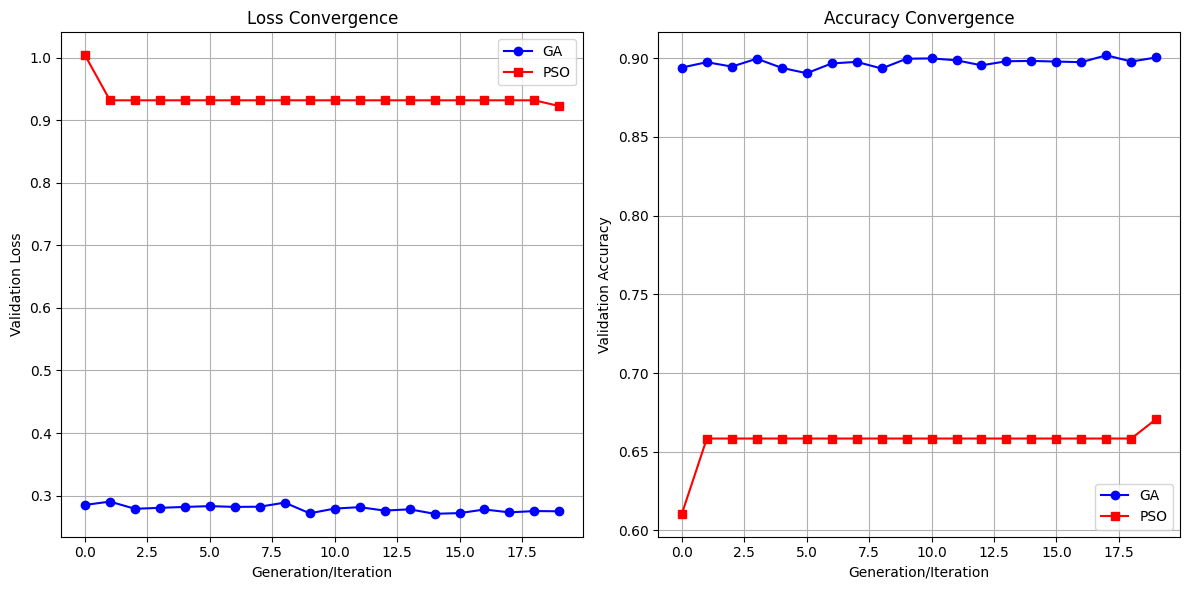

In [ ]:
# 1. CONVERGENCE PLOT
def plot_convergence(ga_history, pso_history):
    plt.figure(figsize=(12, 6))

    # GA data
    ga_loss = [gen['best_loss'] for gen in ga_history]
    ga_acc = [gen['best_acc'] for gen in ga_history]

    # PSO data
    pso_loss = [gen['global_loss'] for gen in pso_history]
    pso_acc = [gen['global_acc'] for gen in pso_history]

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(ga_loss, 'b-o', label='GA')
    plt.plot(pso_loss, 'r-s', label='PSO')
    plt.xlabel('Generation/Iteration')
    plt.ylabel('Validation Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(ga_acc, 'b-o', label='GA')
    plt.plot(pso_acc, 'r-s', label='PSO')
    plt.xlabel('Generation/Iteration')
    plt.ylabel('Validation Accuracy')
    plt.title('Accuracy Convergence')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('convergence.png', dpi=300)
    plt.show()

plot_convergence(ga_history, pso_history)

In [ ]:
# 2. 3D TRAJECTORY ANIMATION
def create_3d_animation(ga_history, pso_history):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Prepare data containers
    ga_points = []
    pso_points = []

    # Create animation function
    def update(frame):
        ax.clear()

        # GA points
        for gen in range(min(frame+1, len(ga_history))):
            for gene in ga_history[gen]['population']:
                x = normalize_param(gene['lr'], 'lr')
                y = normalize_param(gene['conv1_out'], 'conv1_out')
                z = normalize_param(gene['conv2_out'], 'conv2_out')
                ga_points.append((x, y, z))

        # PSO points
        for iter in range(min(frame+1, len(pso_history))):
            for particle in pso_history[iter]['swarm']:
                x = normalize_param(particle['lr'], 'lr')
                y = normalize_param(particle['conv1_out'], 'conv1_out')
                z = normalize_param(particle['conv2_out'], 'conv2_out')
                pso_points.append((x, y, z))

        # Convert to arrays
        if ga_points:
            ga_arr = np.array(ga_points)
            ax.scatter(ga_arr[:,0], ga_arr[:,1], ga_arr[:,2],
                      c='blue', alpha=0.3, s=10, label='GA')

        if pso_points:
            pso_arr = np.array(pso_points)
            ax.scatter(pso_arr[:,0], pso_arr[:,1], pso_arr[:,2],
                      c='red', alpha=0.3, s=10, marker='s', label='PSO')

        # Plot best trajectories
        if ga_history:
            ga_best = []
            for gen in range(min(frame+1, len(ga_history))):
                gene = ga_history[gen]['best_gene']
                x = normalize_param(gene['lr'], 'lr')
                y = normalize_param(gene['conv1_out'], 'conv1_out')
                z = normalize_param(gene['conv2_out'], 'conv2_out')
                ga_best.append((x, y, z))
            ga_best_arr = np.array(ga_best)
            ax.plot(ga_best_arr[:,0], ga_best_arr[:,1], ga_best_arr[:,2],
                   'b-', linewidth=2, label='GA Best')
            ax.scatter(ga_best_arr[-1,0], ga_best_arr[-1,1], ga_best_arr[-1,2],
                      c='gold', s=100, edgecolor='black', label='Current Best')

        if pso_history:
            pso_best = []
            for iter in range(min(frame+1, len(pso_history))):
                particle = pso_history[iter]['global_best']
                x = normalize_param(particle['lr'], 'lr')
                y = normalize_param(particle['conv1_out'], 'conv1_out')
                z = normalize_param(particle['conv2_out'], 'conv2_out')
                pso_best.append((x, y, z))
            pso_best_arr = np.array(pso_best)
            ax.plot(pso_best_arr[:,0], pso_best_arr[:,1], pso_best_arr[:,2],
                   'r-', linewidth=2, label='PSO Best')

        # Set labels and title
        ax.set_xlabel('log10(Learning Rate)')
        ax.set_ylabel('conv1_out')
        ax.set_zlabel('conv2_out')
        ax.set_title(f'Hyperparameter Optimization Trajectories\nGeneration/Iteration: {frame}')
        ax.legend()

        # Set viewing angle
        ax.view_init(30, frame * 2)

    # Create animation
    ani = FuncAnimation(fig, update, frames=max(len(ga_history), len(pso_history)),
                        interval=500, blit=False)

    # Save animation
    ani.save('optimization_trajectory.mp4', writer='ffmpeg', fps=2, dpi=150)
    plt.close()

create_3d_animation(ga_history, pso_history)

NameError: name 'animation' is not defined

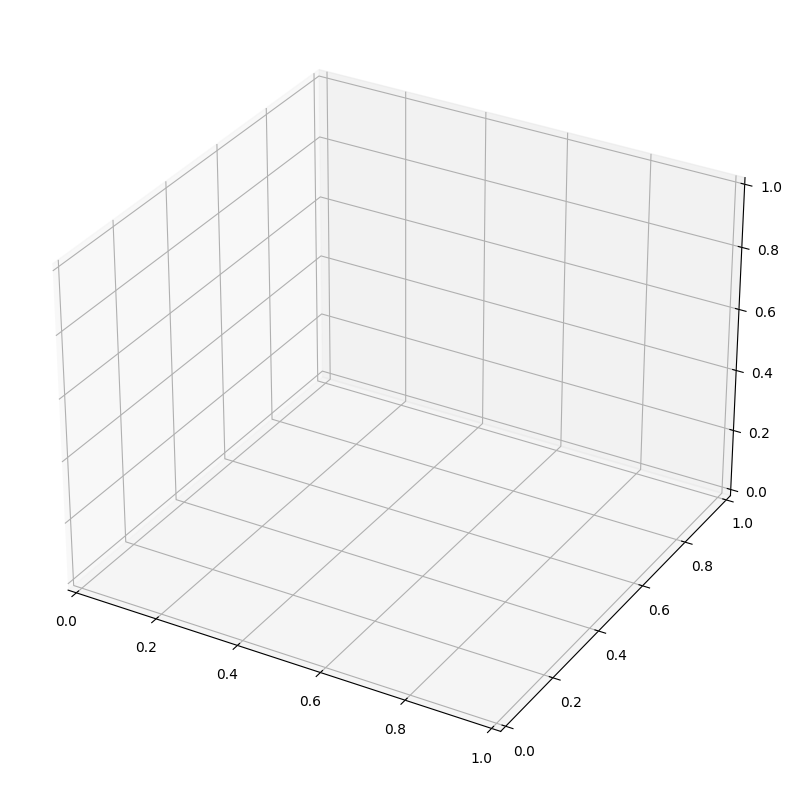

In [ ]:
def create_3d_animation(ga_history, pso_history):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Precompute all points for efficiency
    all_ga_points = []
    all_pso_points = []
    all_ga_best = []
    all_pso_best = []

    # Process GA history
    for gen in range(len(ga_history)):
        gen_ga_points = []
        for gene in ga_history[gen]['population']:
            x = normalize_param(gene['lr'], 'lr')
            y = normalize_param(gene['conv1_out'], 'conv1_out')
            z = normalize_param(gene['conv2_out'], 'conv2_out')
            gen_ga_points.append((x, y, z))
        all_ga_points.append(gen_ga_points)

        # Best GA point
        gene = ga_history[gen]['best_gene']
        x = normalize_param(gene['lr'], 'lr')
        y = normalize_param(gene['conv1_out'], 'conv1_out')
        z = normalize_param(gene['conv2_out'], 'conv2_out')
        all_ga_best.append((x, y, z))

    # Process PSO history
    for iter in range(len(pso_history)):
        gen_pso_points = []
        for particle in pso_history[iter]['swarm']:
            x = normalize_param(particle['lr'], 'lr')
            y = normalize_param(particle['conv1_out'], 'conv1_out')
            z = normalize_param(particle['conv2_out'], 'conv2_out')
            gen_pso_points.append((x, y, z))
        all_pso_points.append(gen_pso_points)

        # Best PSO point
        particle = pso_history[iter]['global_best']
        x = normalize_param(particle['lr'], 'lr')
        y = normalize_param(particle['conv1_out'], 'conv1_out')
        z = normalize_param(particle['conv2_out'], 'conv2_out')
        all_pso_best.append((x, y, z))

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Animation update function
    def update(frame):
        ax.clear()
        artists = []  # List to collect all artists

        # Plot GA points
        ga_x, ga_y, ga_z = [], [], []
        for gen in range(min(frame+1, len(ga_history))):
            for point in all_ga_points[gen]:
                ga_x.append(point[0])
                ga_y.append(point[1])
                ga_z.append(point[2])
        if ga_x:  # Only plot if there are points
            scat_ga = ax.scatter(ga_x, ga_y, ga_z, c='blue', alpha=0.3, s=10, label='GA')
            artists.append(scat_ga)

        # Plot PSO points
        pso_x, pso_y, pso_z = [], [], []
        for iter in range(min(frame+1, len(pso_history))):
            for point in all_pso_points[iter]:
                pso_x.append(point[0])
                pso_y.append(point[1])
                pso_z.append(point[2])
        if pso_x:  # Only plot if there are points
            scat_pso = ax.scatter(pso_x, pso_y, pso_z, c='red', alpha=0.3, s=10, marker='s', label='PSO')
            artists.append(scat_pso)

        # Plot GA best trajectory
        if ga_history and frame < len(ga_history):
            ga_best_x, ga_best_y, ga_best_z = [], [], []
            for gen in range(min(frame+1, len(ga_history))):
                ga_best_x.append(all_ga_best[gen][0])
                ga_best_y.append(all_ga_best[gen][1])
                ga_best_z.append(all_ga_best[gen][2])
            if ga_best_x:  # Only plot if there are points
                line_ga_best, = ax.plot(ga_best_x, ga_best_y, ga_best_z, 'b-', linewidth=2, label='GA Best')
                artists.append(line_ga_best)

                # Current best GA point
                point_best = ax.scatter([ga_best_x[-1]], [ga_best_y[-1]], [ga_best_z[-1]],
                                       c='gold', s=100, edgecolor='black', label='Current Best')
                artists.append(point_best)

        # Plot PSO best trajectory
        if pso_history and frame < len(pso_history):
            pso_best_x, pso_best_y, pso_best_z = [], [], []
            for iter in range(min(frame+1, len(pso_history))):
                pso_best_x.append(all_pso_best[iter][0])
                pso_best_y.append(all_pso_best[iter][1])
                pso_best_z.append(all_pso_best[iter][2])
            if pso_best_x:  # Only plot if there are points
                line_pso_best, = ax.plot(pso_best_x, pso_best_y, pso_best_z, 'r-', linewidth=2, label='PSO Best')
                artists.append(line_pso_best)

                # Current best PSO point
                point_best = ax.scatter([pso_best_x[-1]], [pso_best_y[-1]], [pso_best_z[-1]],
                                       c='lime', s=100, edgecolor='black', label='Current Best')
                artists.append(point_best)

        # Set labels and title
        ax.set_xlabel('log10(Learning Rate)')
        ax.set_ylabel('conv1_out')
        ax.set_zlabel('conv2_out')
        ax.set_title(f'Hyperparameter Optimization Trajectories\nGeneration/Iteration: {frame}')

        # Only create legend if we have artists
        if artists:
            ax.legend()

        # Set viewing angle
        ax.view_init(30, frame * 2)

        return artists

    # Create animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=max(len(ga_history), len(pso_history)),
        interval=500,
        blit=False
    )

    # Close the figure to prevent double display
    plt.close(fig)

    # Return HTML animation
    return HTML(ani.to_jshtml())

# Create and display the animation
animation_html = create_3d_animation(ga_history, pso_history)
animation_html

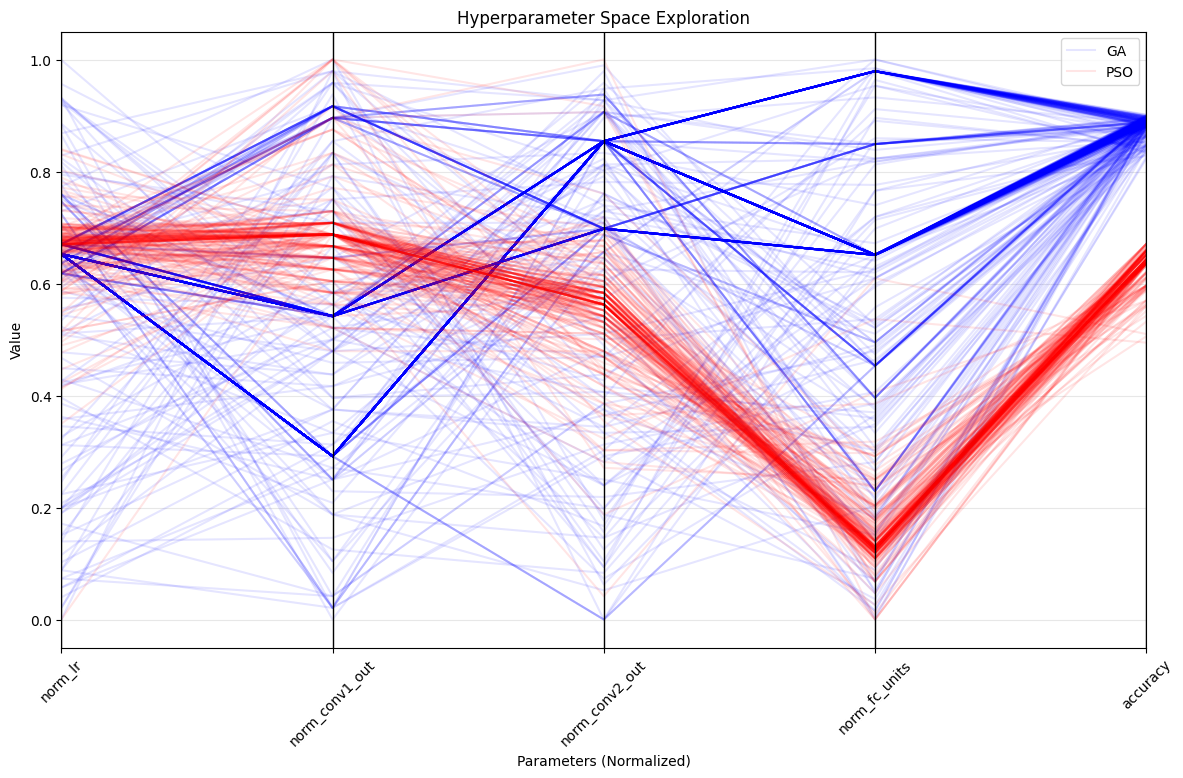

In [ ]:
# 3. PARALLEL COORDINATES PLOT
def plot_parallel_coordinates(ga_history, pso_history):
    data = []

    # Collect GA data
    for gen in ga_history:
        for gene, (loss, acc) in zip(gen['population'], gen['fitness']):
            row = gene.copy()
            row['loss'] = loss
            row['accuracy'] = acc
            row['method'] = 'GA'
            data.append(row)

    # Collect PSO data
    for gen in pso_history:
        for particle, (loss, acc) in zip(gen['swarm'], gen['fitness']):
            row = particle.copy()
            row['loss'] = loss
            row['accuracy'] = acc
            row['method'] = 'PSO'
            data.append(row)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Normalize parameters for better visualization
    for param in param_bounds.keys():
        if param == 'lr':
            df['log_lr'] = np.log10(df['lr'])
            min_val = np.log10(param_bounds['lr'][0])
            max_val = np.log10(param_bounds['lr'][1])
            df['norm_lr'] = (df['log_lr'] - min_val) / (max_val - min_val)
        else:
            min_val = param_bounds[param][0]
            max_val = param_bounds[param][1]
            df[f'norm_{param}'] = (df[param] - min_val) / (max_val - min_val)

    plt.figure(figsize=(14, 8))
    parallel_coordinates(
        df[['method', 'norm_lr', 'norm_conv1_out', 'norm_conv2_out', 'norm_fc_units', 'accuracy']],
        'method',
        color=['blue', 'red'],
        alpha=0.1
    )
    plt.title('Hyperparameter Space Exploration')
    plt.xlabel('Parameters (Normalized)')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.savefig('parallel_coordinates.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_parallel_coordinates(ga_history, pso_history)

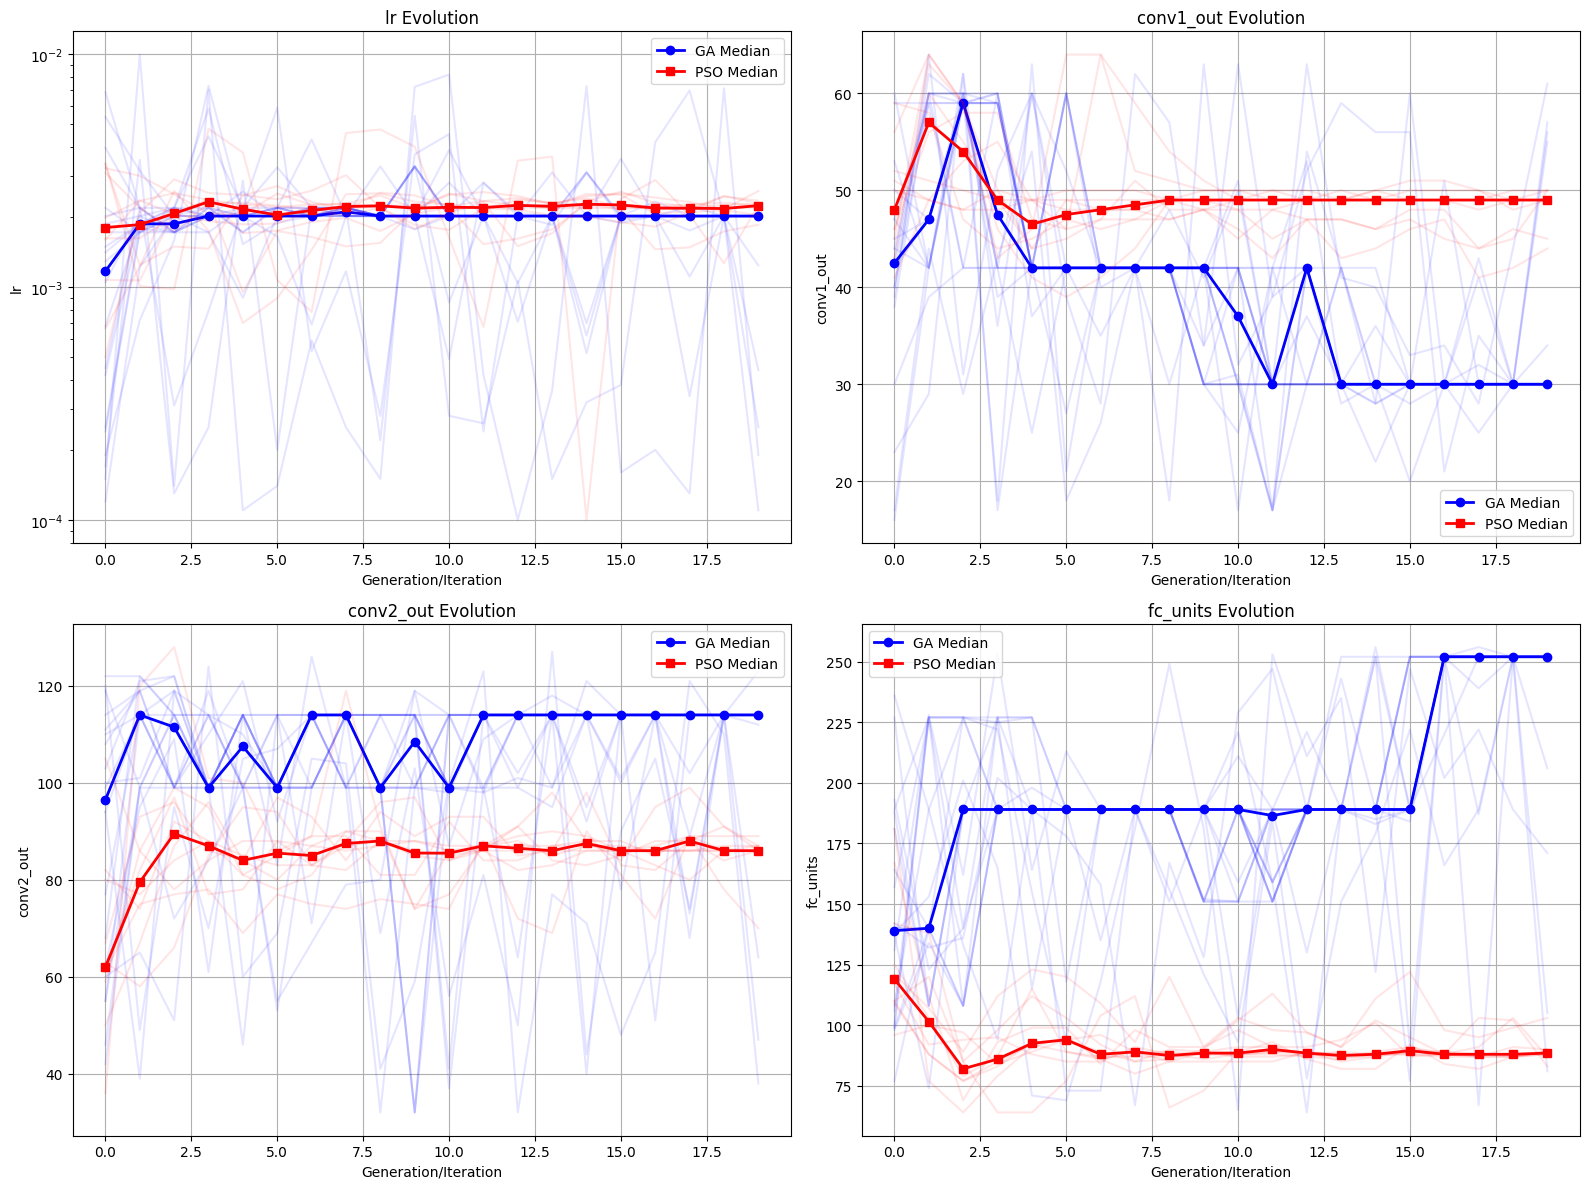

In [ ]:
# 4. HYPERPARAMETER EVOLUTION
def plot_hyperparameter_evolution(ga_history, pso_history):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    params = ['lr', 'conv1_out', 'conv2_out', 'fc_units']

    for i, param in enumerate(params):
        ax = axs[i//2, i%2]

        # GA evolution
        ga_vals = []
        for gen in ga_history:
            gen_vals = [gene[param] for gene in gen['population']]
            ga_vals.append(gen_vals)
        ga_vals = np.array(ga_vals)

        # Plot GA
        for j in range(ga_vals.shape[1]):
            ax.plot(ga_vals[:, j], 'b-', alpha=0.1)
        ax.plot(np.median(ga_vals, axis=1), 'b-o', linewidth=2, label='GA Median')

        # PSO evolution
        pso_vals = []
        for gen in pso_history:
            gen_vals = [particle[param] for particle in gen['swarm']]
            pso_vals.append(gen_vals)
        pso_vals = np.array(pso_vals)

        # Plot PSO
        for j in range(pso_vals.shape[1]):
            ax.plot(pso_vals[:, j], 'r-', alpha=0.1)
        ax.plot(np.median(pso_vals, axis=1), 'r-s', linewidth=2, label='PSO Median')

        # Formatting
        ax.set_xlabel('Generation/Iteration')
        ax.set_ylabel(param)
        if param == 'lr':
            ax.set_yscale('log')
        ax.set_title(f'{param} Evolution')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig('hyperparameter_evolution.png', dpi=300)
    plt.show()

plot_hyperparameter_evolution(ga_history, pso_history)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



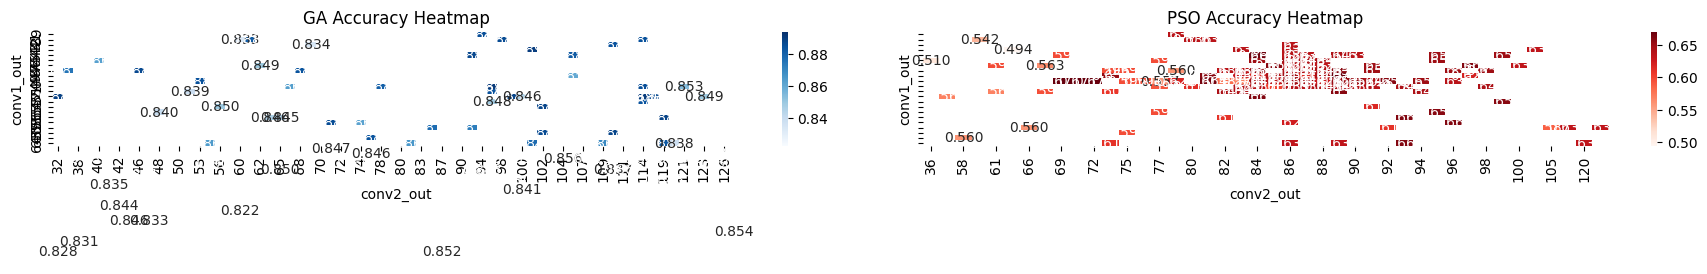

In [ ]:
# 5. PERFORMANCE HEATMAP
def plot_performance_heatmap(ga_history, pso_history):
    # Prepare data
    all_data = []

    # GA data
    for gen in ga_history:
        for gene, (loss, acc) in zip(gen['population'], gen['fitness']):
            all_data.append({
                'method': 'GA',
                'conv1_out': gene['conv1_out'],
                'conv2_out': gene['conv2_out'],
                'accuracy': acc
            })

    # PSO data
    for gen in pso_history:
        for particle, (loss, acc) in zip(gen['swarm'], gen['fitness']):
            all_data.append({
                'method': 'PSO',
                'conv1_out': particle['conv1_out'],
                'conv2_out': particle['conv2_out'],
                'accuracy': acc
            })

    df = pd.DataFrame(all_data)

    # Create pivot tables
    ga_pivot = df[df['method']=='GA'].pivot_table(
        index='conv1_out', columns='conv2_out', values='accuracy', aggfunc='mean'
    )
    pso_pivot = df[df['method']=='PSO'].pivot_table(
        index='conv1_out', columns='conv2_out', values='accuracy', aggfunc='mean'
    )

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # GA heatmap
    sns.heatmap(ga_pivot, annot=True, fmt=".3f", cmap="Blues", ax=ax1)
    ax1.set_title('GA Accuracy Heatmap')
    ax1.set_xlabel('conv2_out')
    ax1.set_ylabel('conv1_out')

    # PSO heatmap
    sns.heatmap(pso_pivot, annot=True, fmt=".3f", cmap="Reds", ax=ax2)
    ax2.set_title('PSO Accuracy Heatmap')
    ax2.set_xlabel('conv2_out')

    plt.tight_layout()
    plt.savefig('performance_heatmap.png', dpi=300)
    plt.show()

plot_performance_heatmap(ga_history, pso_history)

In [ ]:
# 6. INTERACTIVE 3D PLOT (PLOTLY)
def create_interactive_3d(ga_history, pso_history):
    # Prepare data
    ga_data = []
    pso_data = []

    # GA points
    for gen in ga_history:
        for gene, (loss, acc) in zip(gen['population'], gen['fitness']):
            ga_data.append({
                'x': np.log10(gene['lr']),
                'y': gene['conv1_out'],
                'z': gene['conv2_out'],
                'accuracy': acc,
                'fc_units': gene['fc_units'],
                'generation': gen['generation']
            })

    # PSO points
    for gen in pso_history:
        for particle, (loss, acc) in zip(gen['swarm'], gen['fitness']):
            pso_data.append({
                'x': np.log10(particle['lr']),
                'y': particle['conv1_out'],
                'z': particle['conv2_out'],
                'accuracy': acc,
                'fc_units': particle['fc_units'],
                'iteration': gen['iteration']
            })

    # Create GA trace
    ga_df = pd.DataFrame(ga_data)
    ga_trace = go.Scatter3d(
        x=ga_df['x'],
        y=ga_df['y'],
        z=ga_df['z'],
        mode='markers',
        marker=dict(
            size=ga_df['fc_units']/50,
            color=ga_df['accuracy'],
            colorscale='Blues',
            opacity=0.7,
            colorbar=dict(title='Accuracy')
        ),
        name='GA',
        hovertext=ga_df.apply(lambda row:
            f"Accuracy: {row['accuracy']:.4f}<br>"
            f"LR: {10**row['x']:.5f}<br>"
            f"conv1: {row['y']}<br>"
            f"conv2: {row['z']}<br>"
            f"fc: {row['fc_units']}<br>"
            f"Gen: {row['generation']}", axis=1)
    )

    # Create PSO trace
    pso_df = pd.DataFrame(pso_data)
    pso_trace = go.Scatter3d(
        x=pso_df['x'],
        y=pso_df['y'],
        z=pso_df['z'],
        mode='markers',
        marker=dict(
            size=pso_df['fc_units']/50,
            color=pso_df['accuracy'],
            colorscale='Reds',
            opacity=0.7,
            colorbar=dict(title='Accuracy')
        ),
        name='PSO',
        hovertext=pso_df.apply(lambda row:
            f"Accuracy: {row['accuracy']:.4f}<br>"
            f"LR: {10**row['x']:.5f}<br>"
            f"conv1: {row['y']}<br>"
            f"conv2: {row['z']}<br>"
            f"fc: {row['fc_units']}<br>"
            f"Iter: {row['iteration']}", axis=1)
    )

    # Create figure
    fig = go.Figure(data=[ga_trace, pso_trace])

    # Set layout
    fig.update_layout(
        title='Hyperparameter Optimization Space',
        scene=dict(
            xaxis_title='log10(Learning Rate)',
            yaxis_title='conv1_out',
            zaxis_title='conv2_out',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1200,
        height=800
    )

    # Save and show
    fig.write_html("interactive_optimization.html")
    fig.show()

create_interactive_3d(ga_history, pso_history)

**Combination**

Using device: cuda

--- Running Adam Baseline ---
Seed 1/3 | Test Acc: 0.9117 | Time: 65.02s
Seed 2/3 | Test Acc: 0.9089 | Time: 64.25s
Seed 3/3 | Test Acc: 0.9160 | Time: 64.11s

--- Running SGD with Random Search ---
Searching for best params over 20 trials...
Search complete. Best val_acc: 0.7438. Best params: {'lr': 0.0013292918943162155, 'momentum': 0.9658500101408589, 'batch_size': 128, 'weight_decay': 0.0015702970884055383}
Training final model with best params over 3 seeds...
Seed 1/3 | Test Acc: 0.8786 | Time: 59.60s
Seed 2/3 | Test Acc: 0.8787 | Time: 58.80s
Seed 3/3 | Test Acc: 0.8757 | Time: 59.07s

--- Running L-BFGS with Random Search ---
Searching for best params over 20 trials...
Search complete. Best val_acc: 0.7658. Best params: {'lr': 0.05611516415334504, 'batch_size': 1024, 'weight_decay': 0.007114476009343417}
Training final model with best params over 3 seeds...
Seed 1/3 | Test Acc: 0.8611 | Time: 158.59s
Seed 2/3 | Test Acc: 0.8650 | Time: 159.12s
Seed 3/3 | Test

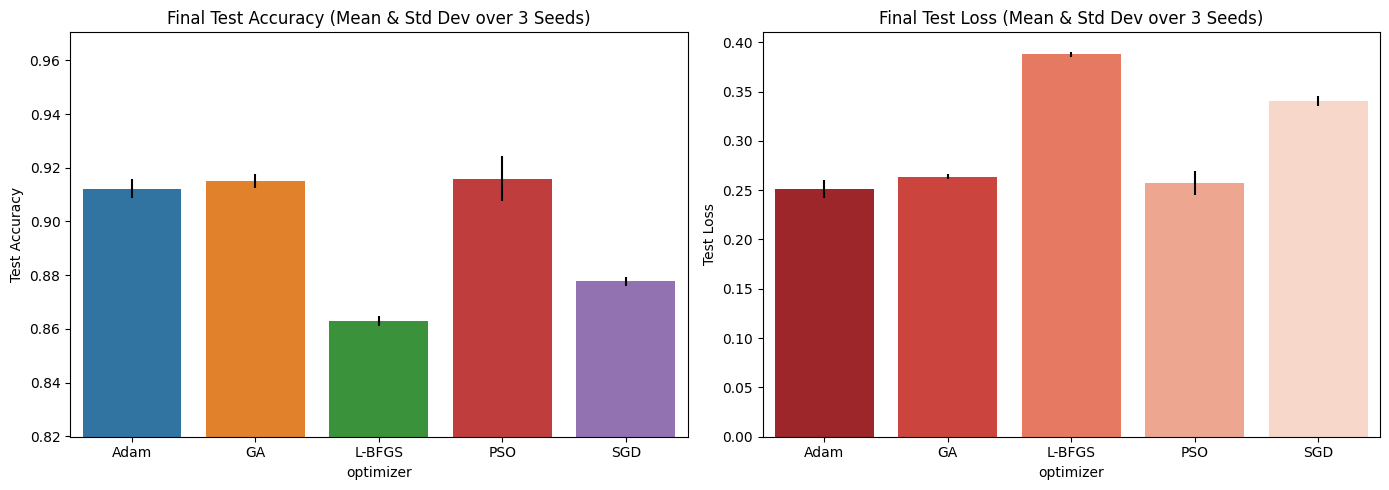

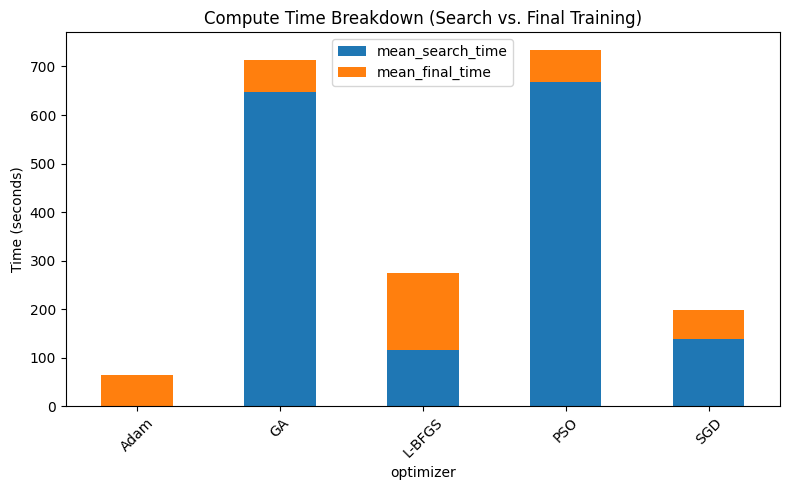

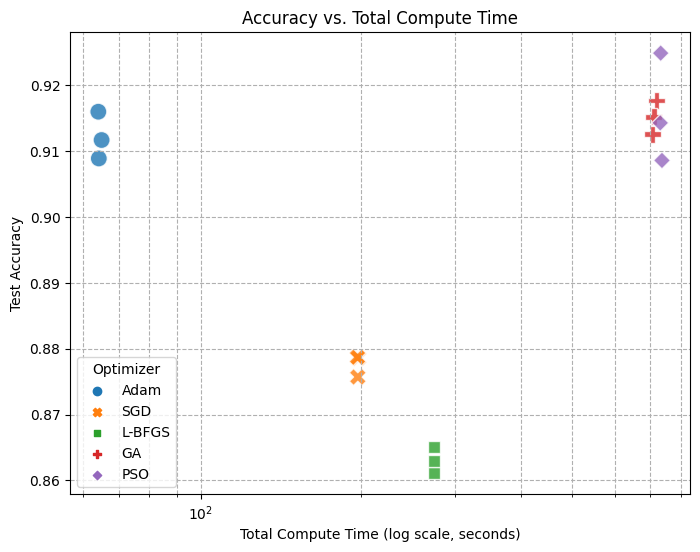

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



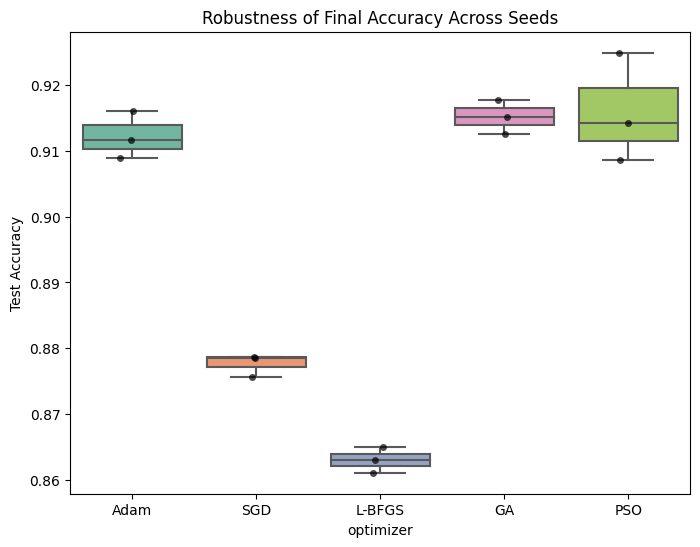


--- Tukey HSD Results ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Adam     GA    0.003 0.9132 -0.0087  0.0146  False
  Adam L-BFGS  -0.0492    0.0 -0.0608 -0.0375   True
  Adam    PSO   0.0037 0.8259 -0.0079  0.0154  False
  Adam    SGD  -0.0345    0.0 -0.0462 -0.0229   True
    GA L-BFGS  -0.0521    0.0 -0.0638 -0.0405   True
    GA    PSO   0.0008 0.9994 -0.0109  0.0124  False
    GA    SGD  -0.0375    0.0 -0.0492 -0.0258   True
L-BFGS    PSO   0.0529    0.0  0.0412  0.0646   True
L-BFGS    SGD   0.0146 0.0138   0.003  0.0263   True
   PSO    SGD  -0.0383    0.0 -0.0499 -0.0266   True
----------------------------------------------------


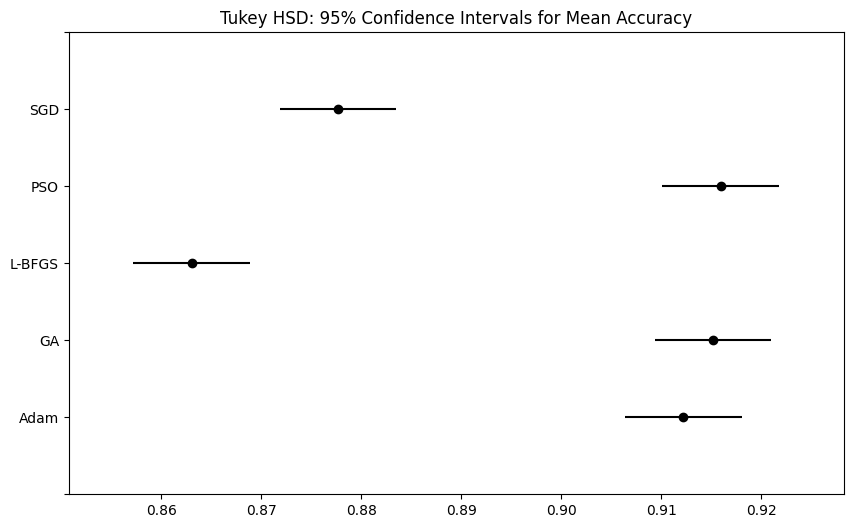

In [ ]:
import time
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind, friedmanchisquare
from statsmodels.stats.multicomp import MultiComparison

# ------------------------------------------------------------------
# 1. Global Configuration & Setup
# ------------------------------------------------------------------

# --- Experiment Config ---
NUM_SEEDS = 3
NUM_SEARCH_TRIALS = 20 # For SGD and L-BFGS random search
FINAL_TRAINING_EPOCHS = 5

# --- GA Config ---
POP_SIZE = 10
GENERATIONS = 20

# --- PSO Config ---
PSO_PARTICLES = 10
PSO_GENERATIONS = 20

# --- Device & Seeds ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# --- Resource Tracking ---
def get_memory_mb():
    if torch.cuda.is_available():
        # Returns peak memory usage in MB since the last reset
        return torch.cuda.max_memory_allocated(DEVICE) / 1024**2
    else:
        # Returns current RSS memory of the process
        return psutil.Process().memory_info().rss / 1024**2

def reset_memory_tracking():
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(DEVICE)

# ------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Full datasets for final training and testing
full_train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Create a smaller 5000-sample validation set for hyperparameter tuning
train_ds, val_ds = random_split(full_train_dataset, [55000, 5000])

# Create a smaller subset of the training data for faster search evaluations
search_train_subset = Subset(train_ds, list(range(10000)))

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ------------------------------------------------------------------
# 3. Model Definitions
# ------------------------------------------------------------------

# Model with a fixed architecture (for Adam, SGD, L-BFGS)
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64 * 7 * 7, 128), nn.ReLU(), nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

# Model with a variable architecture (for GA, PSO)
class CustomCNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, fc_units):
        super().__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Ensure flatten_size is an integer for the nn.Linear layer
        self.flatten_size = int(conv2_out * 7 * 7)
        self.fc1 = nn.Linear(self.flatten_size, int(fc_units))
        self.fc2 = nn.Linear(int(fc_units), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------
# 4. Core Training & Evaluation Functions
# ------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()

def train_model(model, dl, optimizer, epochs, use_closure=False, wd=0.0):
    model.train()
    for _ in range(epochs):
        for X, y in dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            if use_closure:
                def closure():
                    optimizer.zero_grad()
                    out = model(X)
                    loss = criterion(out, y)
                    if wd > 0:
                        l2_reg = sum(p.pow(2).sum() for p in model.parameters())
                        loss = loss + wd * l2_reg
                    loss.backward()
                    return loss
                optimizer.step(closure)
            else:
                optimizer.zero_grad()
                loss = criterion(model(X), y)
                loss.backward()
                optimizer.step()

def evaluate_model(model, dl):
    model.eval()
    total, correct, loss = 0, 0, 0.0
    with torch.no_grad():
        for X, y in dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss += criterion(out, y).item() * y.size(0) # Weighted by batch size
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss / total, correct / total

# ------------------------------------------------------------------
# 5. Optimizer-Specific Implementations (Search & Final Eval)
# ------------------------------------------------------------------

# --- 5.1 ADAM (BASELINE) ---
def run_adam_baseline():
    print("\n--- Running Adam Baseline ---")
    records = []
    for seed in range(NUM_SEEDS):
        set_seeds(seed)
        model = FashionCNN().to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)

        reset_memory_tracking()
        start_time = time.time()

        train_model(model, full_train_loader, optimizer, epochs=FINAL_TRAINING_EPOCHS)

        compute_time = time.time() - start_time
        mem_usage = get_memory_mb()
        test_loss, test_acc = evaluate_model(model, test_loader)

        print(f"Seed {seed+1}/{NUM_SEEDS} | Test Acc: {test_acc:.4f} | Time: {compute_time:.2f}s")
        records.append({
            'optimizer': 'Adam', 'seed': seed, 'test_acc': test_acc, 'test_loss': test_loss,
            'search_time': 0, 'final_train_time': compute_time, 'memory_mb': mem_usage,
            'best_params': {'lr': 1e-3, 'batch_size': 64}
        })
    return records

# --- 5.2 SGD (RANDOM SEARCH) ---
def run_sgd_search():
    print("\n--- Running SGD with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-4, -1),
        'momentum': lambda: np.random.uniform(0.5, 0.99),
        'batch_size': lambda: random.choice([32, 64, 128]),
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print(f"Searching for best params over {NUM_SEARCH_TRIALS} trials...")
    search_start = time.time()
    best_config, best_val_acc = None, -1
    search_train_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

    for _ in range(NUM_SEARCH_TRIALS):
        set_seeds(42) # Use fixed seed for search comparison
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
        # Use a smaller loader for faster search
        search_loader_trial = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)
        train_model(model, search_loader_trial, optimizer, epochs=3)
        _, val_acc = evaluate_model(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = config
    search_time = time.time() - search_start
    print(f"Search complete. Best val_acc: {best_val_acc:.4f}. Best params: {best_config}")

    # Final Evaluation Phase
    print(f"Training final model with best params over {NUM_SEEDS} seeds...")
    records = []
    for seed in range(NUM_SEEDS):
        set_seeds(seed)
        model = FashionCNN().to(DEVICE)
        bs = int(best_config['batch_size'])
        optimizer = optim.SGD(model.parameters(), lr=best_config['lr'], momentum=best_config['momentum'], weight_decay=best_config['weight_decay'])
        full_train_loader = DataLoader(full_train_dataset, batch_size=bs, shuffle=True)

        reset_memory_tracking()
        start_time = time.time()
        train_model(model, full_train_loader, optimizer, epochs=FINAL_TRAINING_EPOCHS)
        final_train_time = time.time() - start_time
        mem_usage = get_memory_mb()
        test_loss, test_acc = evaluate_model(model, test_loader)

        print(f"Seed {seed+1}/{NUM_SEEDS} | Test Acc: {test_acc:.4f} | Time: {final_train_time:.2f}s")
        records.append({
            'optimizer': 'SGD', 'seed': seed, 'test_acc': test_acc, 'test_loss': test_loss,
            'search_time': search_time, 'final_train_time': final_train_time, 'memory_mb': mem_usage,
            'best_params': best_config
        })
    return records


# --- 5.3 L-BFGS (RANDOM SEARCH) ---
def run_lbfgs_search():
    print("\n--- Running L-BFGS with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-2, 0),
        'batch_size': lambda: random.choice([256, 512, 1024]), # LBFGS works better with larger batches
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print(f"Searching for best params over {NUM_SEARCH_TRIALS} trials...")
    search_start = time.time()
    best_config, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

    for _ in range(NUM_SEARCH_TRIALS):
        set_seeds(42)
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.LBFGS(model.parameters(), lr=config['lr'], max_iter=10, line_search_fn="strong_wolfe")
        search_loader_trial = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)

        train_model(model, search_loader_trial, optimizer, epochs=1, use_closure=True, wd=config['weight_decay'])
        _, val_acc = evaluate_model(model, val_loader)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = config
    search_time = time.time() - search_start
    print(f"Search complete. Best val_acc: {best_val_acc:.4f}. Best params: {best_config}")

    # Final Evaluation Phase
    print(f"Training final model with best params over {NUM_SEEDS} seeds...")
    records = []
    for seed in range(NUM_SEEDS):
        set_seeds(seed)
        model = FashionCNN().to(DEVICE)
        bs = int(best_config['batch_size'])
        optimizer = optim.LBFGS(model.parameters(), lr=best_config['lr'], max_iter=10, line_search_fn="strong_wolfe")
        full_train_loader = DataLoader(full_train_dataset, batch_size=bs, shuffle=True)

        reset_memory_tracking()
        start_time = time.time()
        train_model(model, full_train_loader, optimizer, epochs=FINAL_TRAINING_EPOCHS, use_closure=True, wd=best_config['weight_decay'])
        final_train_time = time.time() - start_time
        mem_usage = get_memory_mb()
        test_loss, test_acc = evaluate_model(model, test_loader)

        print(f"Seed {seed+1}/{NUM_SEEDS} | Test Acc: {test_acc:.4f} | Time: {final_train_time:.2f}s")
        records.append({
            'optimizer': 'L-BFGS', 'seed': seed, 'test_acc': test_acc, 'test_loss': test_loss,
            'search_time': search_time, 'final_train_time': final_train_time, 'memory_mb': mem_usage,
            'best_params': best_config
        })
    return records


# --- 5.4 GENETIC ALGORITHM (GA) ---
def run_ga_experiment():
    print("\n--- Running Genetic Algorithm (GA) Search ---")
    param_bounds = {
        "lr": [1e-4, 1e-2], "conv1_out": [16, 64],
        "conv2_out": [32, 128], "fc_units": [64, 256],
    }

    def random_gene():
        return {
            "lr": 10 ** random.uniform(np.log10(param_bounds['lr'][0]), np.log10(param_bounds['lr'][1])),
            "conv1_out": random.randint(*param_bounds['conv1_out']),
            "conv2_out": random.randint(*param_bounds['conv2_out']),
            "fc_units": random.randint(*param_bounds['fc_units'])
        }

    def evaluate_gene(gene):
        # Use a small subset to evaluate fitness quickly
        search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
        # Correctly pass hyperparameters to CustomCNN
        model = CustomCNN(conv1_out=int(gene['conv1_out']),
                          conv2_out=int(gene['conv2_out']),
                          fc_units=int(gene['fc_units'])).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=gene['lr'])
        train_model(model, search_loader, optimizer, epochs=1)
        loss, acc = evaluate_model(model, val_loader)
        return loss # GA minimizes the loss

    def run_search(seed):
        set_seeds(seed)
        search_start = time.time()
        population = [random_gene() for _ in range(POP_SIZE)]
        best_overall_gene, best_overall_loss = None, float('inf')

        for gen in range(GENERATIONS):
            fitness_scores = [evaluate_gene(gene) for gene in population]

            sorted_pop = sorted(zip(fitness_scores, population), key=lambda x: x[0])
            if sorted_pop[0][0] < best_overall_loss:
                best_overall_loss = sorted_pop[0][0]
                best_overall_gene = sorted_pop[0][1]

            top_k = [gene for _, gene in sorted_pop[:POP_SIZE//2]]
            new_pop = top_k[:] # Elitism
            while len(new_pop) < POP_SIZE:
                p1, p2 = random.sample(top_k, 2)
                child = {k: p1[k] if random.random() < 0.5 else p2[k] for k in p1}
                # Mutation
                if random.random() < 0.2:
                    key_to_mutate = random.choice(list(param_bounds.keys()))
                    child[key_to_mutate] = random_gene()[key_to_mutate]
                new_pop.append(child)
            population = new_pop
        search_time = time.time() - search_start
        # Ensure discrete values are integers in the final returned gene
        best_overall_gene_int = {k: (int(v) if k != 'lr' else v) for k, v in best_overall_gene.items()}
        print(f"Seed {seed+1}/{NUM_SEEDS} | Search Time: {search_time:.2f}s | Best Gene: {best_overall_gene_int}")
        return best_overall_gene_int, search_time

    records = []
    for seed in range(NUM_SEEDS):
        best_gene, search_time = run_search(seed)

        # Correctly pass hyperparameters to CustomCNN
        final_model = CustomCNN(conv1_out=int(best_gene['conv1_out']),
                                conv2_out=int(best_gene['conv2_out']),
                                fc_units=int(best_gene['fc_units'])).to(DEVICE)
        final_optimizer = optim.Adam(final_model.parameters(), lr=best_gene['lr'])
        full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)

        reset_memory_tracking()
        start_time = time.time()
        train_model(final_model, full_train_loader, final_optimizer, epochs=FINAL_TRAINING_EPOCHS)
        final_train_time = time.time() - start_time
        mem_usage = get_memory_mb()

        test_loss, test_acc = evaluate_model(final_model, test_loader)
        print(f"Seed {seed+1}/{NUM_SEEDS} | Test Acc: {test_acc:.4f} | Final Train Time: {final_train_time:.2f}s")

        records.append({
            'optimizer': 'GA', 'seed': seed, 'test_acc': test_acc, 'test_loss': test_loss,
            'search_time': search_time, 'final_train_time': final_train_time, 'memory_mb': mem_usage,
            'best_params': best_gene
        })
    return records


# --- 5.5 PARTICLE SWARM OPTIMIZATION (PSO) ---
def run_pso_experiment():
    print("\n--- Running Particle Swarm Optimization (PSO) Search ---")
    param_bounds = {
        "lr": [1e-4, 1e-2], "conv1_out": [16, 64],
        "conv2_out": [32, 128], "fc_units": [64, 256],
    }

    def evaluate_particle(params):
        search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
        # Correctly pass hyperparameters to CustomCNN
        model = CustomCNN(conv1_out=int(params['conv1_out']),
                          conv2_out=int(params['conv2_out']),
                          fc_units=int(params['fc_units'])).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, search_loader, optimizer, epochs=1)
        loss, _ = evaluate_model(model, val_loader)
        return loss # PSO minimizes the loss

    def run_search(seed, w=0.5, c1=1.5, c2=1.5):
        set_seeds(seed)
        search_start = time.time()

        # Correctly initialize particles with both continuous and discrete-like bounds
        particles = []
        for _ in range(PSO_PARTICLES):
            p = {}
            for k, b in param_bounds.items():
                if k == 'lr':
                    p[k] = 10 ** random.uniform(np.log10(b[0]), np.log10(b[1]))
                else:
                    # Initialize discrete-like params as floats within bounds for velocity updates
                    p[k] = random.uniform(b[0], b[1])
            particles.append(p)


        velocities = [{k: 0 for k in p} for p in particles]
        personal_best_pos = deepcopy(particles)
        personal_best_scores = [evaluate_particle(p) for p in particles]
        global_best_score = min(personal_best_scores)
        global_best_pos = deepcopy(particles[np.argmin(personal_best_scores)])

        for _ in range(PSO_GENERATIONS):
            for i in range(PSO_PARTICLES):
                # Update velocity and position
                for k in particles[i]:
                    r1, r2 = random.random(), random.random()
                    velocities[i][k] = (w * velocities[i][k] +
                                        c1 * r1 * (personal_best_pos[i][k] - particles[i][k]) +
                                        c2 * r2 * (global_best_pos[k] - particles[i][k]))
                    particles[i][k] += velocities[i][k]

                # Clip position to bounds
                for k, b in param_bounds.items():
                    particles[i][k] = np.clip(particles[i][k], b[0], b[1])

                # Evaluate new position
                score = evaluate_particle(particles[i])
                if score < personal_best_scores[i]:
                    personal_best_scores[i] = score
                    personal_best_pos[i] = deepcopy(particles[i])
                if score < global_best_score:
                    global_best_score = score
                    global_best_pos = deepcopy(particles[i])

        search_time = time.time() - search_start
        # Convert continuous params to discrete where needed for the final model
        best_params = {k: (int(round(v)) if k != 'lr' else v) for k, v in global_best_pos.items()}
        print(f"Seed {seed+1}/{NUM_SEEDS} | Search Time: {search_time:.2f}s | Best Params: {best_params}")
        return best_params, search_time

    records = []
    for seed in range(NUM_SEEDS):
        best_params, search_time = run_search(seed)

        # Correctly pass hyperparameters to CustomCNN
        final_model = CustomCNN(conv1_out=int(best_params['conv1_out']),
                                conv2_out=int(best_params['conv2_out']),
                                fc_units=int(best_params['fc_units'])).to(DEVICE)
        final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
        full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)

        reset_memory_tracking()
        start_time = time.time()
        train_model(final_model, full_train_loader, final_optimizer, epochs=FINAL_TRAINING_EPOCHS)
        final_train_time = time.time() - start_time
        mem_usage = get_memory_mb()

        test_loss, test_acc = evaluate_model(final_model, test_loader)
        print(f"Seed {seed+1}/{NUM_SEEDS} | Test Acc: {test_acc:.4f} | Final Train Time: {final_train_time:.2f}s")

        records.append({
            'optimizer': 'PSO', 'seed': seed, 'test_acc': test_acc, 'test_loss': test_loss,
            'search_time': search_time, 'final_train_time': final_train_time, 'memory_mb': mem_usage,
            'best_params': best_params
        })
    return records

# ------------------------------------------------------------------
# 6. Main Execution & Data Collection
# ------------------------------------------------------------------
if __name__ == "__main__":
    all_records = []
    all_records.extend(run_adam_baseline())
    all_records.extend(run_sgd_search())
    all_records.extend(run_lbfgs_search())
    all_records.extend(run_ga_experiment())
    all_records.extend(run_pso_experiment())

    df = pd.DataFrame(all_records)
    df['total_time'] = df['search_time'] + df['final_train_time']

    print("\n--- Final Results DataFrame ---")
    print(df[['optimizer', 'seed', 'test_acc', 'total_time', 'memory_mb']])

    # ------------------------------------------------------------------
    # 7. Visualization and Statistical Analysis
    # ------------------------------------------------------------------
    print("\n--- Generating Plots and Analysis ---")

    # 1. Performance Comparison: Bar chart with error bars
    perf = df.groupby('optimizer').agg(
        mean_acc=('test_acc', 'mean'),
        std_acc=('test_acc', 'std'),
        mean_loss=('test_loss', 'mean'),
        std_loss=('test_loss', 'std')
    ).reset_index()

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.barplot(data=perf, x='optimizer', y='mean_acc', yerr=perf['std_acc'].values, ax=ax[0], capsize=.1)
    ax[0].set_title("Final Test Accuracy (Mean & Std Dev over 3 Seeds)")
    ax[0].set_ylabel("Test Accuracy")
    ax[0].set_ylim(bottom=max(0, perf['mean_acc'].min() * 0.95))


    sns.barplot(data=perf, x='optimizer', y='mean_loss', yerr=perf['std_loss'].values, ax=ax[1], palette='Reds_r', capsize=.1)
    ax[1].set_title("Final Test Loss (Mean & Std Dev over 3 Seeds)")
    ax[1].set_ylabel("Test Loss")
    plt.tight_layout()
    plt.show()

    # 2. Efficiency Analysis (Time)
    time_df = df.groupby('optimizer').agg(
        mean_search_time=('search_time', 'mean'),
        mean_final_time=('final_train_time', 'mean')
    ).reset_index()
    time_df.plot(x='optimizer', kind='bar', stacked=True,
                 title='Compute Time Breakdown (Search vs. Final Training)',
                 figsize=(8, 5))
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Accuracy vs. Total Time
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='total_time', y='test_acc', hue='optimizer', style='optimizer', s=150, alpha=0.8)
    plt.xscale('log')
    plt.xlabel("Total Compute Time (log scale, seconds)")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs. Total Compute Time")
    plt.legend(title='Optimizer')
    plt.grid(True, which="both", ls="--")
    plt.show()

    # 4. Robustness Comparison (Box Plot)
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='optimizer', y='test_acc', palette='Set2')
    sns.stripplot(data=df, x='optimizer', y='test_acc', color='black', size=5, jitter=True, alpha=0.7)
    plt.title("Robustness of Final Accuracy Across Seeds")
    plt.ylabel("Test Accuracy")
    plt.show()

    # 5. Statistical Significance Testing (Tukey HSD)
    mc = MultiComparison(df['test_acc'], df['optimizer'])
    res = mc.tukeyhsd()
    print("\n--- Tukey HSD Results ---")
    print(res)
    res.plot_simultaneous()
    plt.title("Tukey HSD: 95% Confidence Intervals for Mean Accuracy")
    plt.show()